In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from skimage import io, color, transform, feature
# import my_measures # note, this was updated March 27; make sure you are using the current version! 
%matplotlib inline

In [4]:
# file paths/names

root_dir = '/home/wolfm2'
root_dir = '/home/eydu'

ci_path = root_dir + '/plane_data/cropped_images_18/' # cropped images for training
l_file = root_dir + '/plane_data/plane_labels_2018.csv' # csv with labels

# get labels and extract features from images

In [5]:
# all labels
plane_data = pd.read_csv(l_file)
print(plane_data.head())
print(plane_data.shape)

                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
(6758, 2)


In [6]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
dims = (15, 35) # 25% of the original size, 525 pixels

In [46]:
import cv2 as cv

'''
def quantize(raster, n_colors):
    raster = color.rgb2lab(color.rgba2rgb(raster))
    
    width, height, depth = raster.shape
    reshaped_raster = np.reshape(raster, (width * height, depth))

    model = cluster.KMeans(n_clusters=n_colors)
    labels = model.fit_predict(reshaped_raster)
    palette = model.cluster_centers_

    quantized_raster = np.reshape(
        palette[labels], (width, height, palette.shape[1]))

    return color.lab2rgb(quantized_raster)
'''

from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

def quantize(raster, n_colors):
    width, height, depth = raster.shape
    reshaped_raster = np.reshape(
        raster, (width * height, depth))

    palette = shuffle(reshaped_raster)[:n_colors]
    labels = pairwise_distances_argmin(
        reshaped_raster, palette)

    quantized_raster = np.reshape(
        palette[labels], (width, height, palette.shape[1]))

    return quantized_raster

downscaled image shape: 
(60, 140)


example of transformation: 


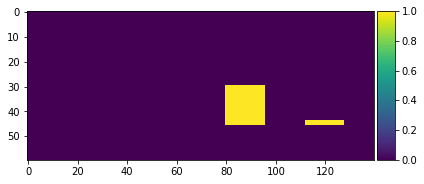

In [68]:
# scikit-image documentation on methods used for feature extraction: 
#    http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray
#    http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
#    http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

from scipy import ndimage
from skimage import exposure
from skimage.filters import threshold_otsu, threshold_adaptive, gaussian
import cv2 as cv
'''
def image_manipulation(imname, imview=False):
    warnings.filterwarnings('ignore')
    imname = ci_path + imname + '.png'
    img_raw = io.imread(imname)[20:35, 30:110]  # [y1:y2, x1,x2] 
    gray = color.rgb2gray(img_raw) # remove color
    gamma = exposure.adjust_gamma(gray, 1.2)
    canny = feature.canny(gamma, sigma=3.5)
    filled = ndimage.binary_fill_holes(canny)
    downscaled = transform.resize(filled, (dims[0], dims[1])) # downscale image
    gThresh = threshold_otsu(downscaled)
    gThreshImg = downscaled > gThresh
    
    final_image = gThreshImg
    # downscaled = transform.resize(gray, (dims[0], dims[1])) # downscale image
    # final_image = feature.canny(downscaled) # edge filter image with Canny algorithm
    if imview==True:
        io.imshow(final_image)
    warnings.filterwarnings('always')
    return final_image
'''
def image_manipulation(imname, imview=False):
    warnings.filterwarnings('ignore')
    imname = ci_path + imname + '.png'
    
    img_raw = cv.imread(imname)
    # img = color.rgb2gray(img_raw) # remove color
    img = exposure.adjust_gamma(img_raw, 1.2)   
    
    # img = quantize(img, 6)
    # img = gaussian(img)
    
    #b_channel, g_channel, r_channel = cv2.split(img)
    #alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 50 #creating a dummy alpha channel image.
    #img = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
    
    #print("TEST" + img.shape())
    
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (10,10, 120, 40)
    cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]
    # plt.imshow(img),plt.colorbar(),plt.show()
    
     
    gray = color.rgb2gray(img) # remove color
    downscaled = transform.resize(gray, (dims[0], dims[1])) # downscale image
    canny = feature.canny(downscaled) # edge filter image with Canny algorithm
    #filled = ndimage.binary_fill_holes(canny) # adds more false negatives!
    
    # final_image = canny
    final_image = mask2
    
    if imview==True:
        io.imshow(final_image)
    warnings.filterwarnings('always')
    return final_image

# focus on representing all true cases better

# test the function, look at input/output
# test_image = image_manipulation('2017-08-25T23+24+13_390Z', True)
# test_image = image_manipulation('2016-10-07T17+50+29_740Z', True) # Assumed good??
#test_image = image_manipulation('2016-08-15T14+26+53_630Z', True)  # Pos Trouble 
# test_image = image_manipulation('2016-10-23T15+42+16_886Z', True)  # Neg Trouble
test_image = image_manipulation('2016-08-08T13+37+31_150Z', True)  # Neg Trouble
print('downscaled image shape: ')
print(test_image.shape)
# print('image representation (first row of pixels): ')
# print(test_image[0])
print('\n')
print('example of transformation: ')

# print(test_image.sum())
# print(test_image)
# n = '2017-08-25T23+24+13_390Z'
# select_indices = list(np.where(plane_data["img_name"] == n)[0])
# plane_data.iloc[select_indices]

In [58]:
# plane_data['num_true'] = 0
# plane_data['num_true'][1] = 1

nTrue = []
nFalse = []
# plt.hist(x)

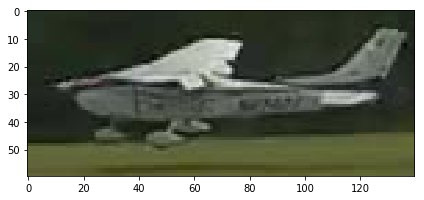

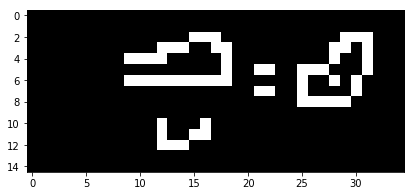

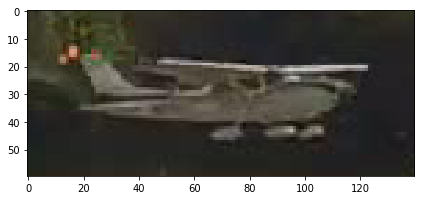

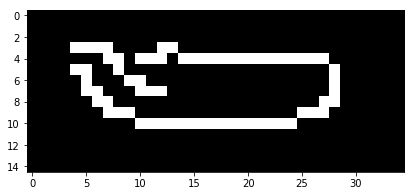

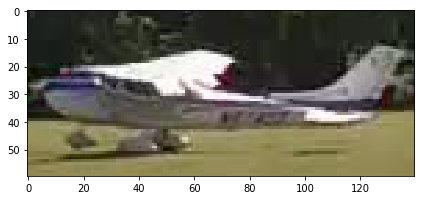

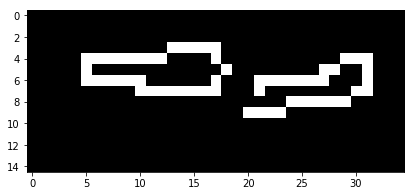

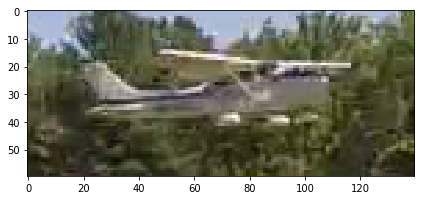

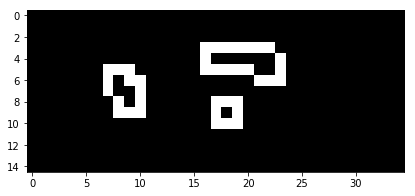

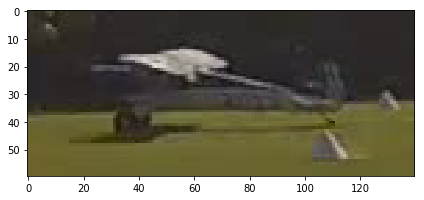

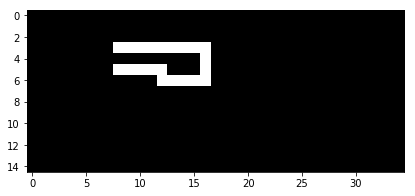

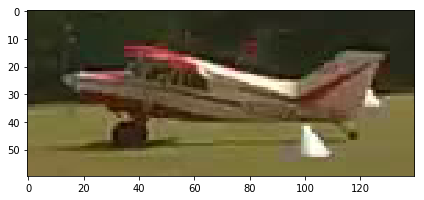

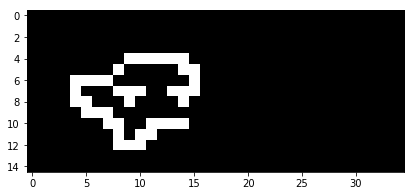

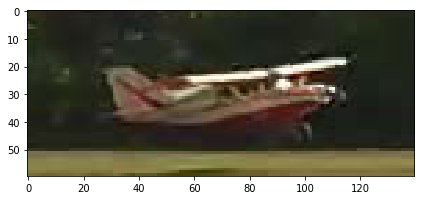

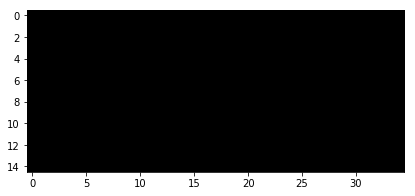

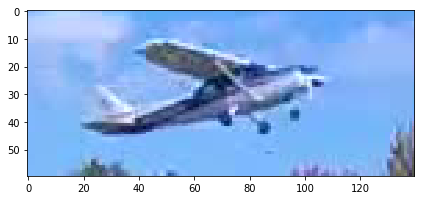

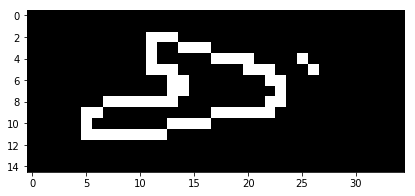

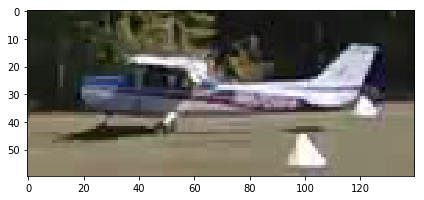

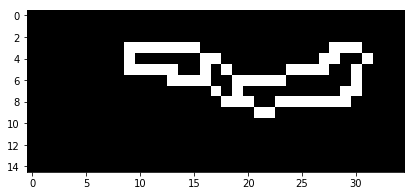

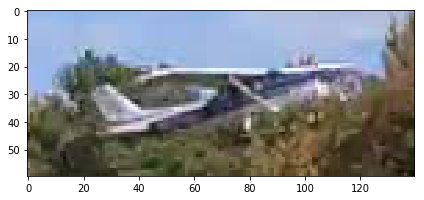

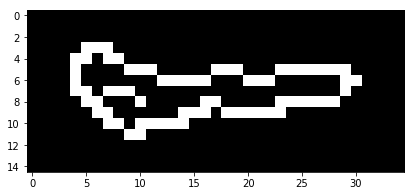

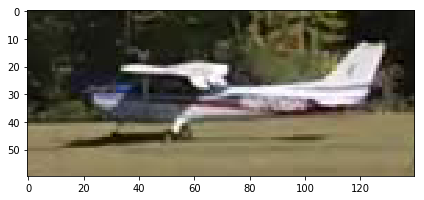

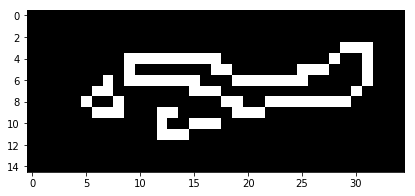

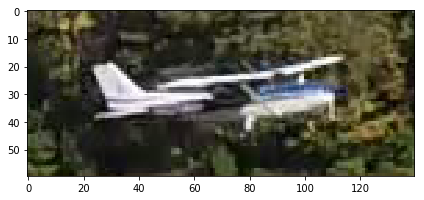

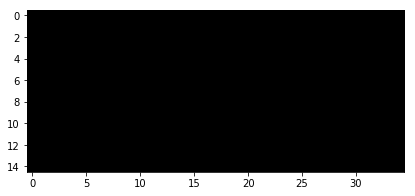

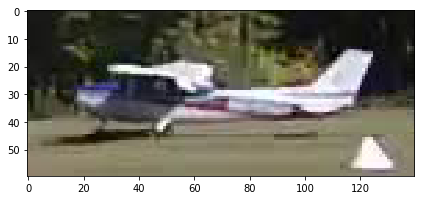

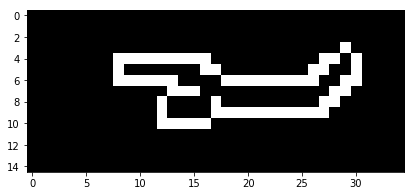

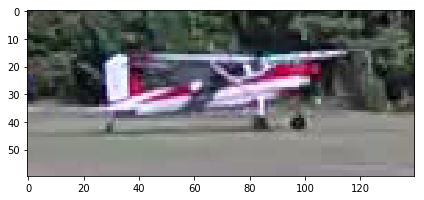

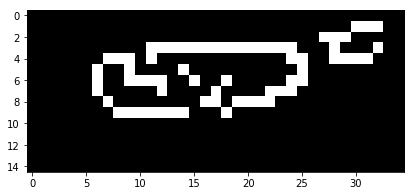

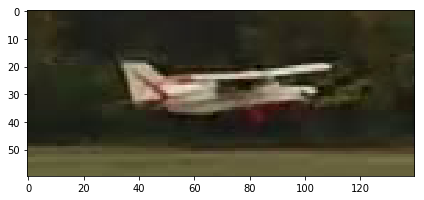

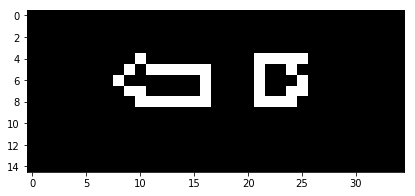

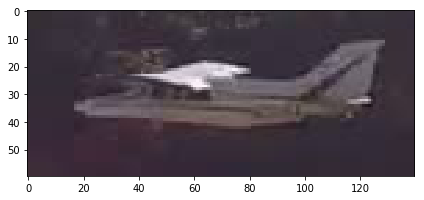

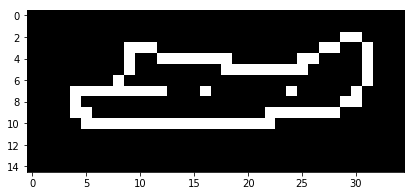

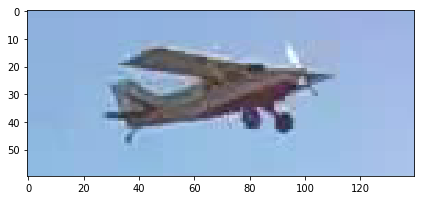

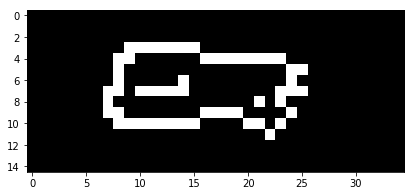

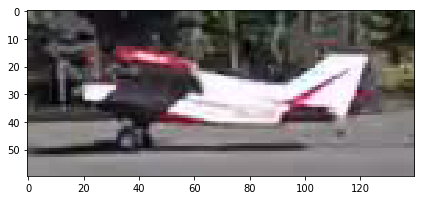

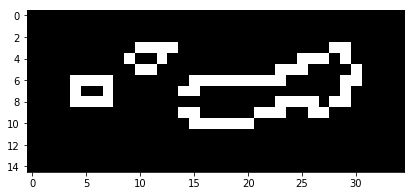

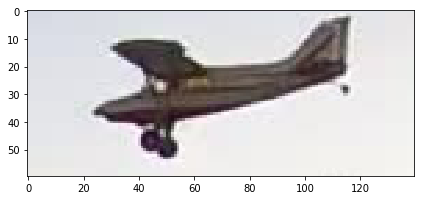

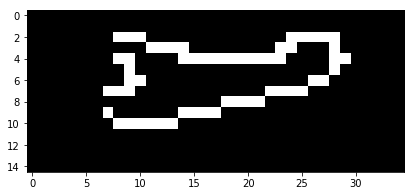

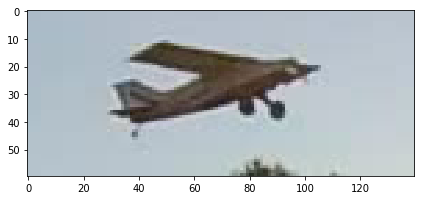

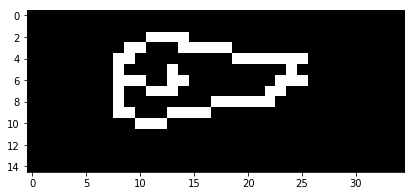

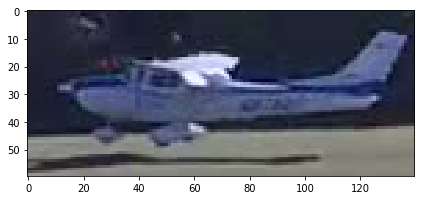

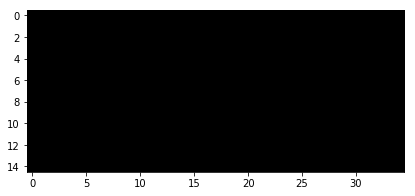

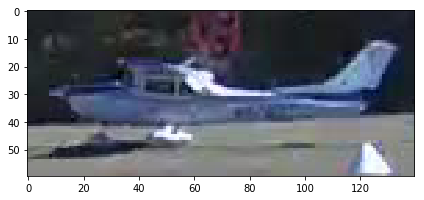

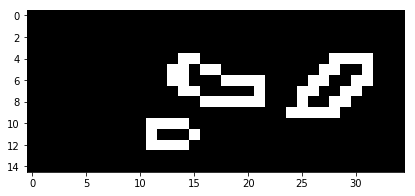

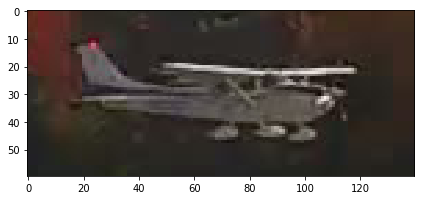

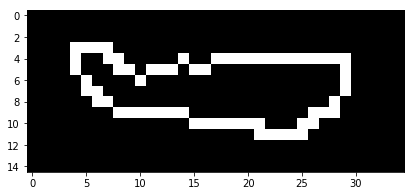

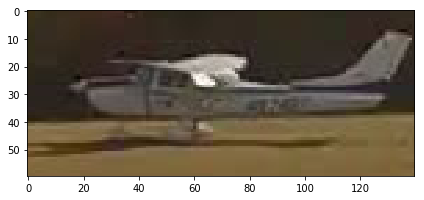

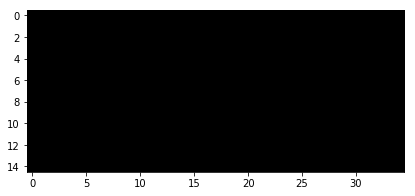

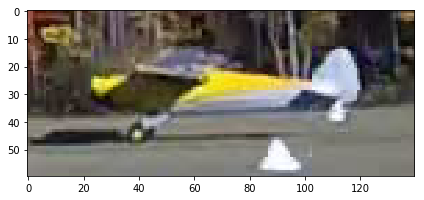

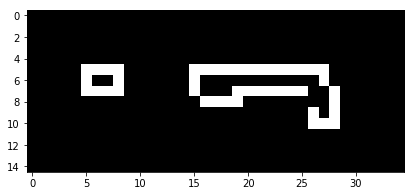

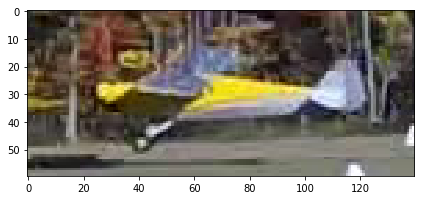

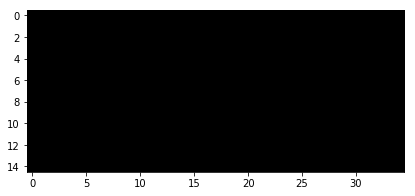

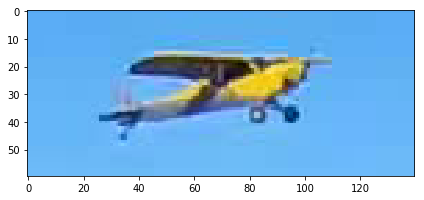

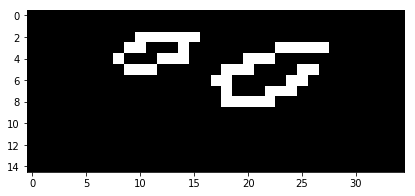

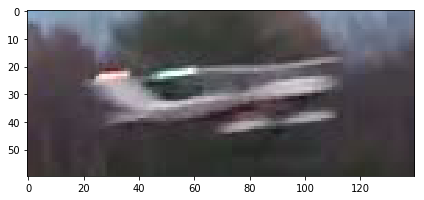

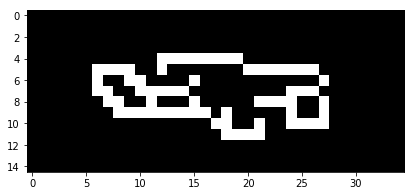

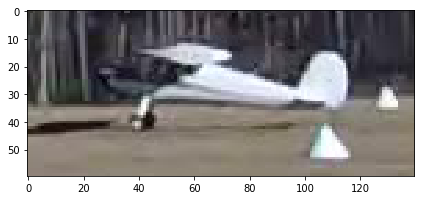

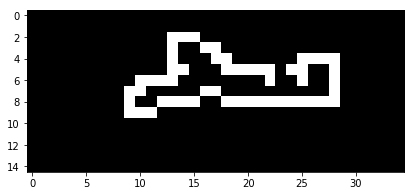

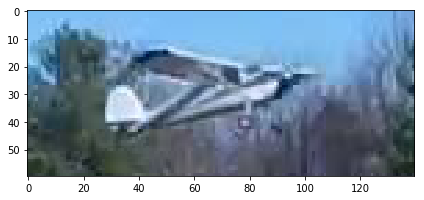

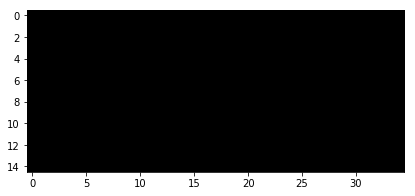

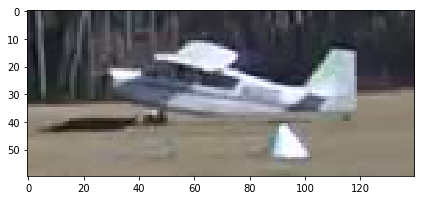

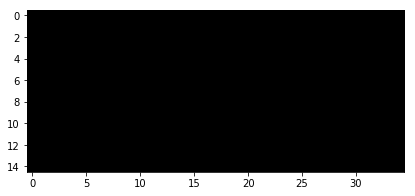

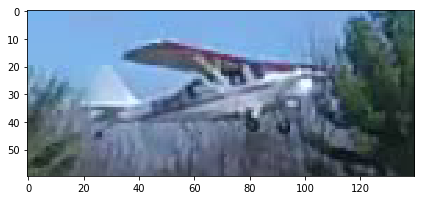

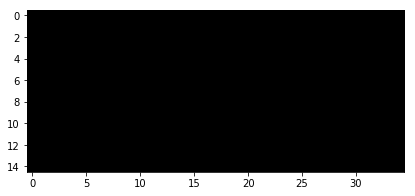

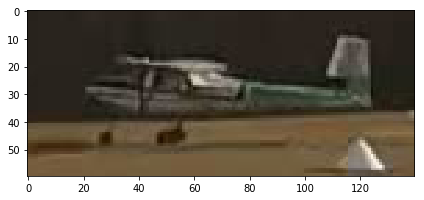

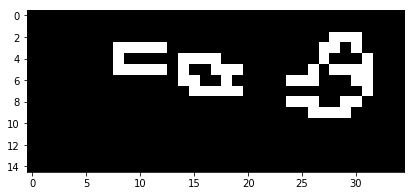

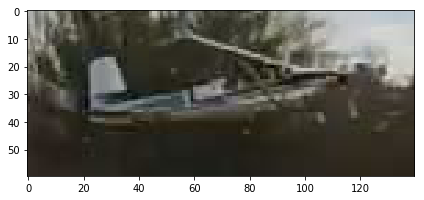

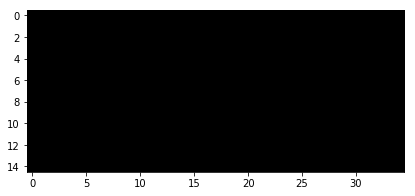

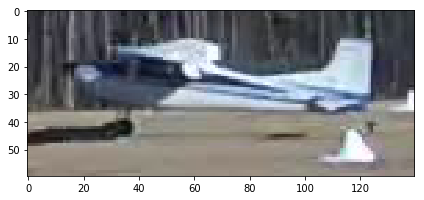

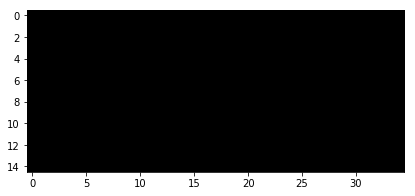

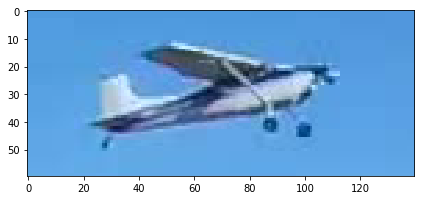

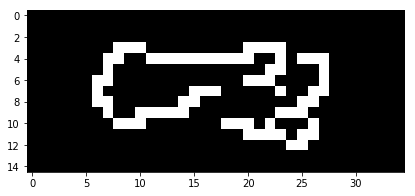

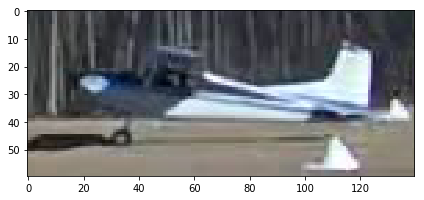

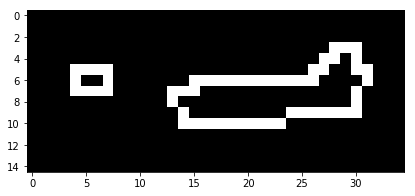

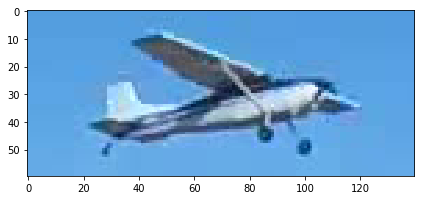

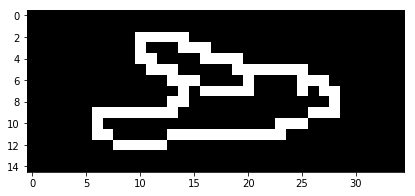

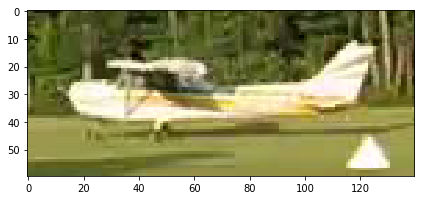

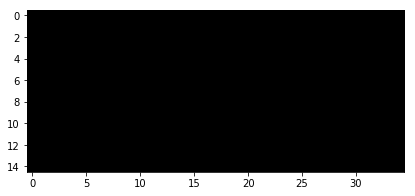

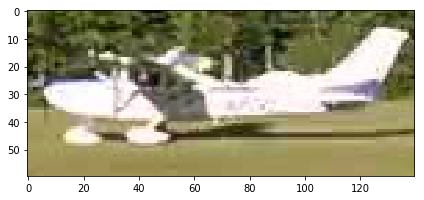

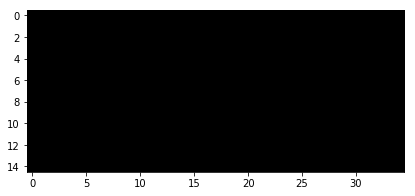

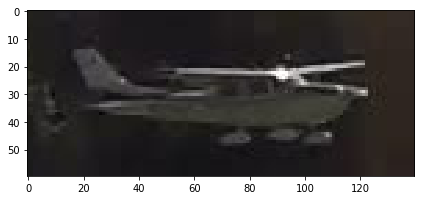

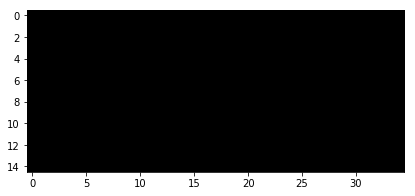

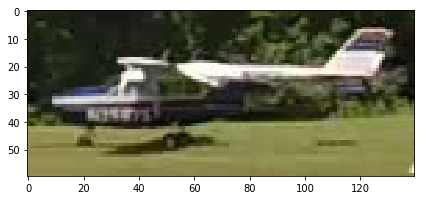

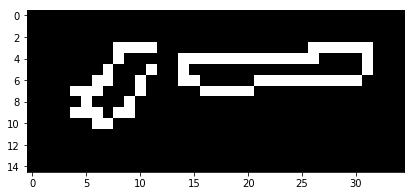

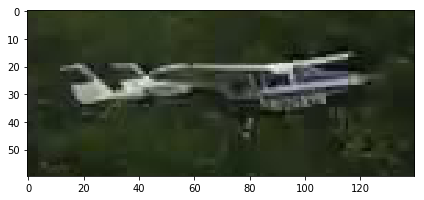

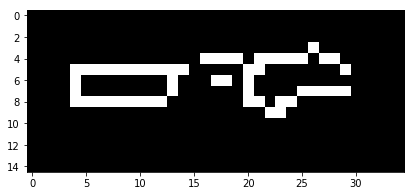

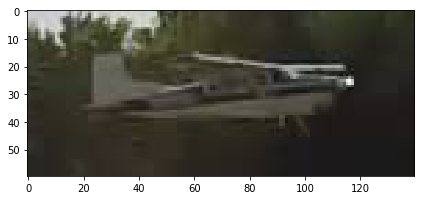

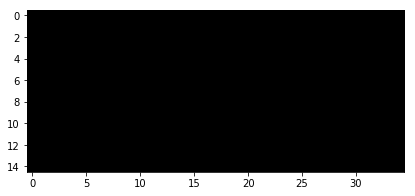

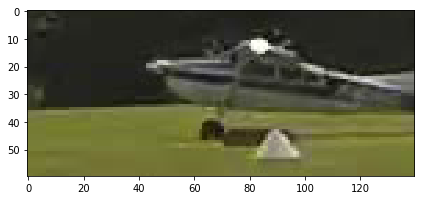

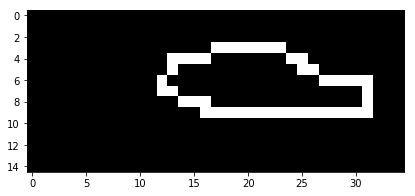

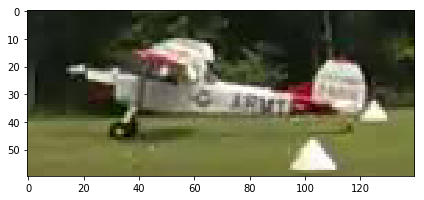

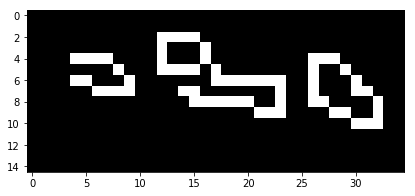

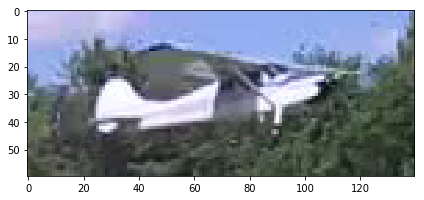

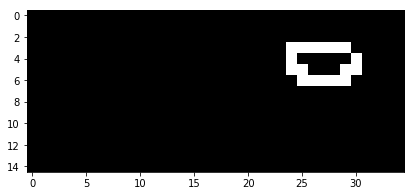

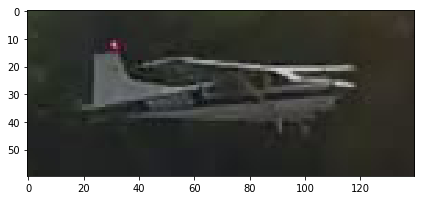

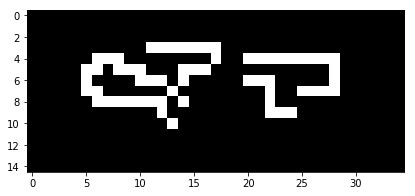

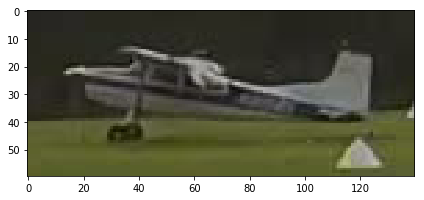

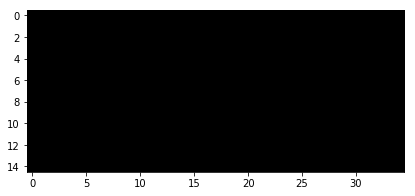

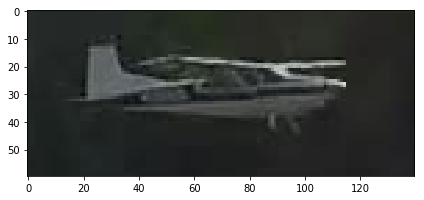

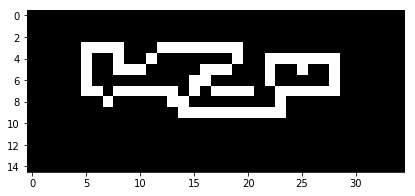

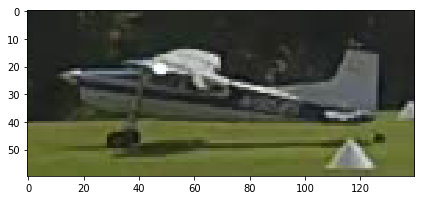

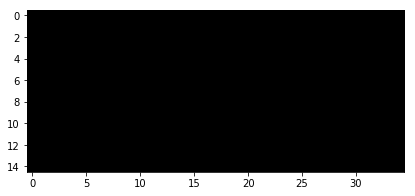

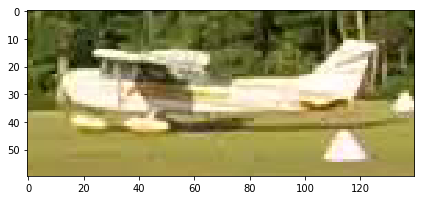

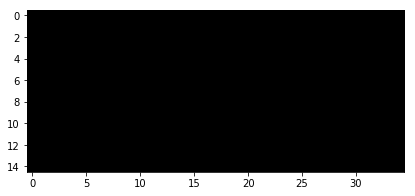

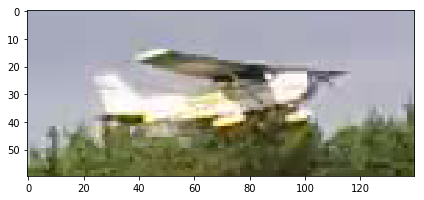

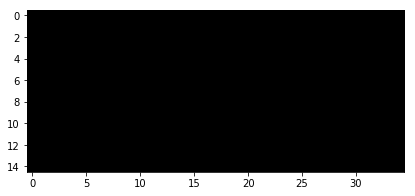

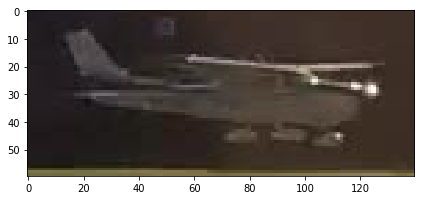

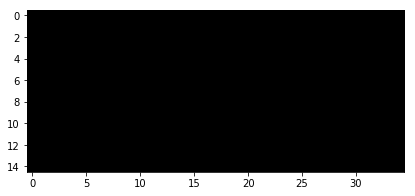

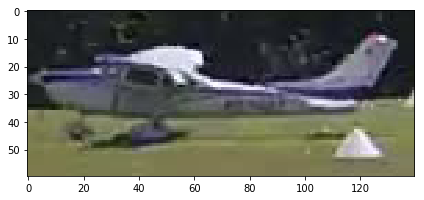

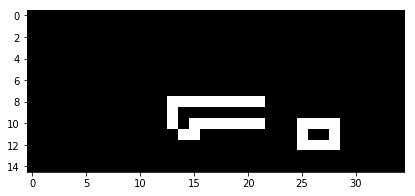

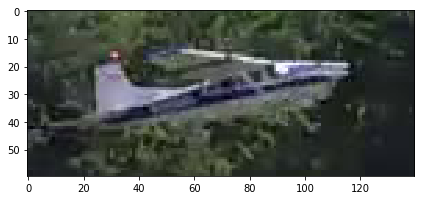

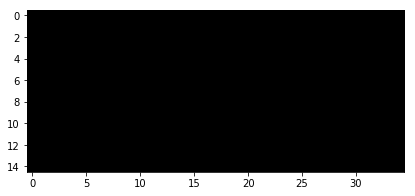

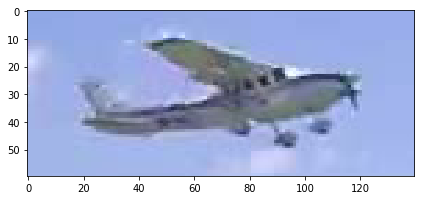

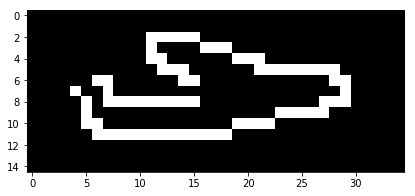

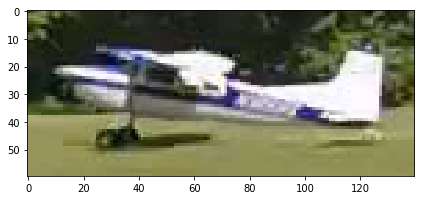

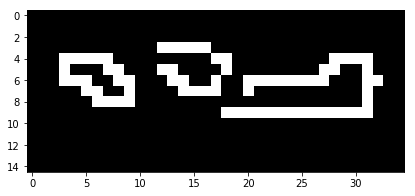

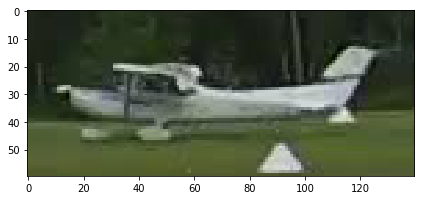

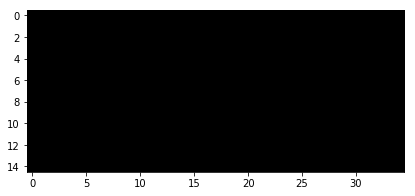

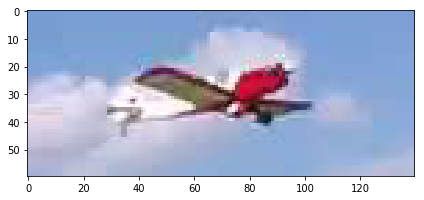

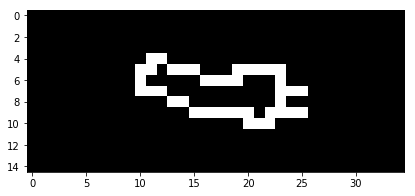

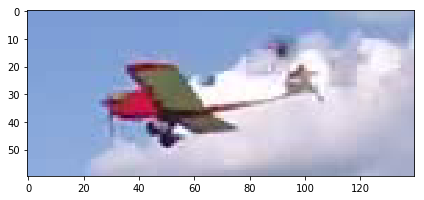

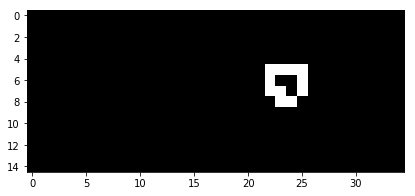

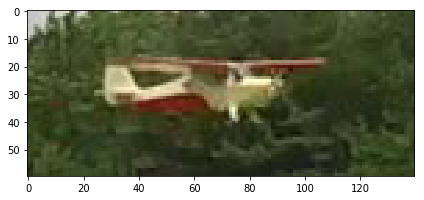

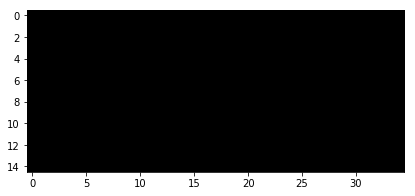

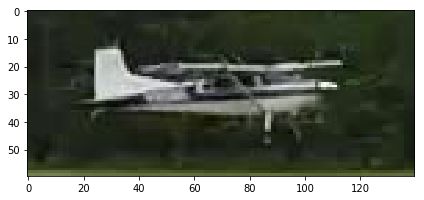

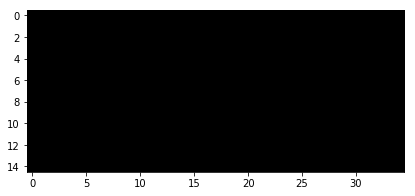

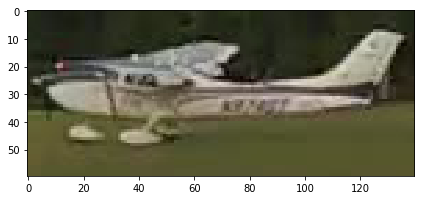

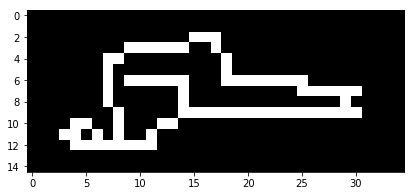

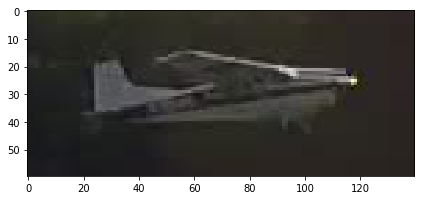

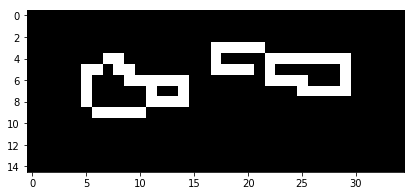

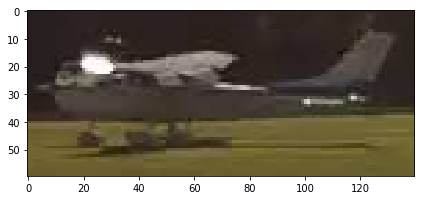

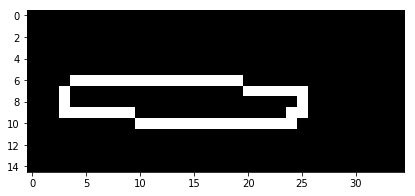

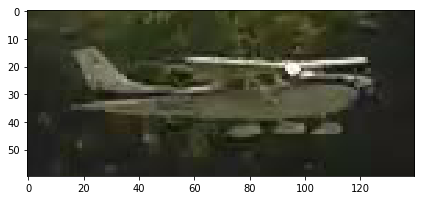

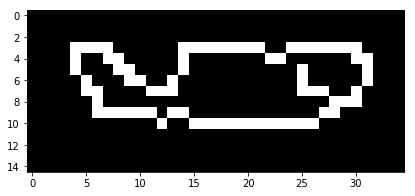

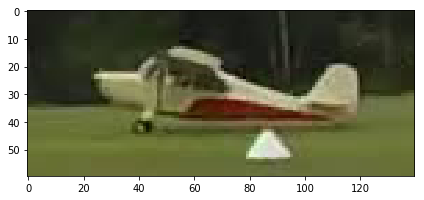

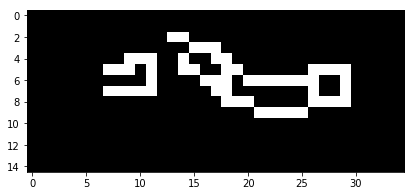

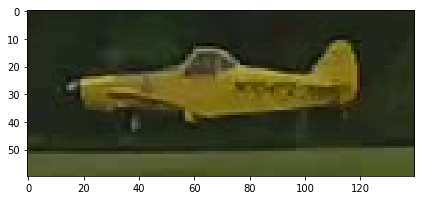

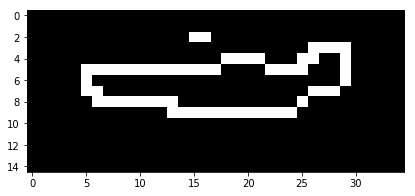

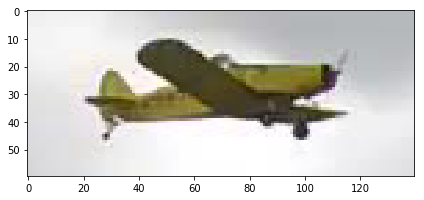

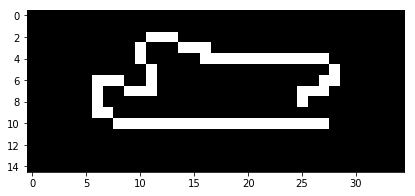

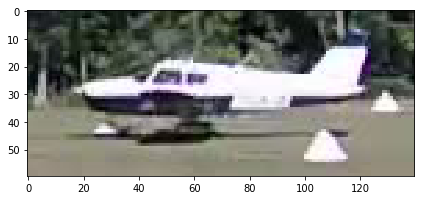

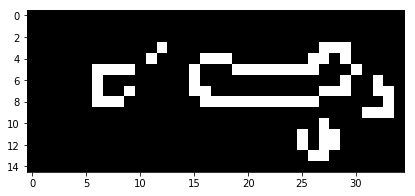

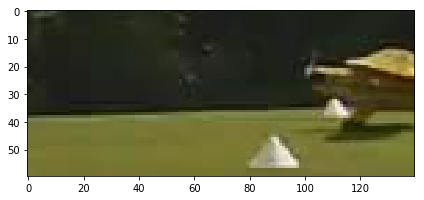

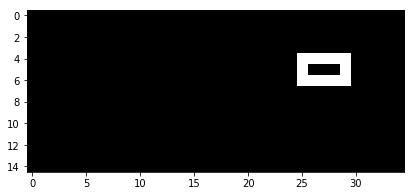

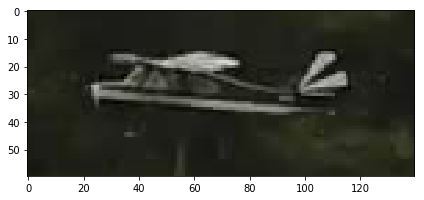

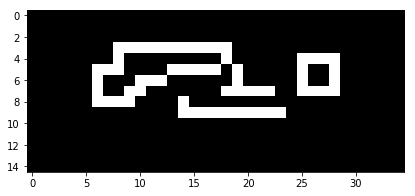

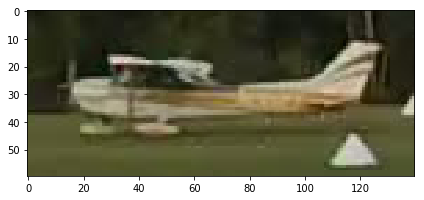

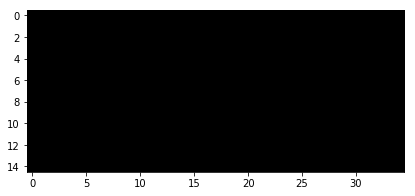

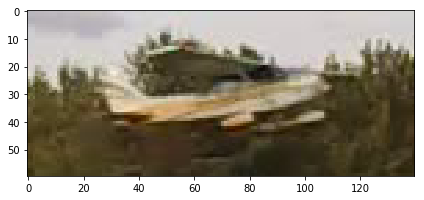

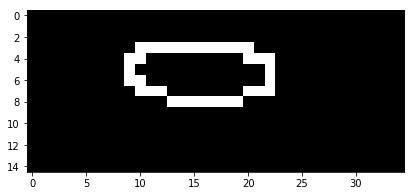

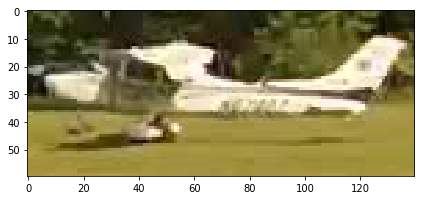

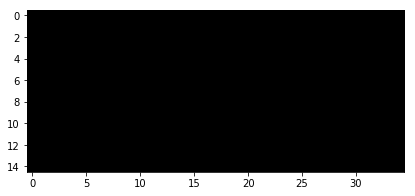

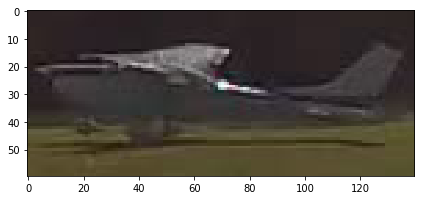

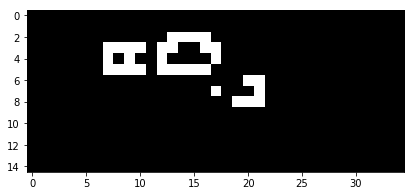

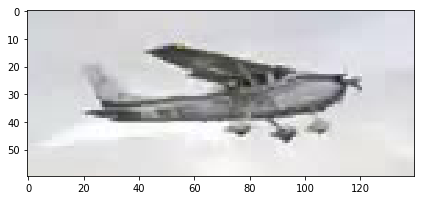

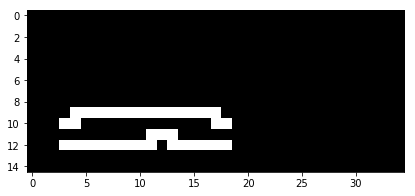

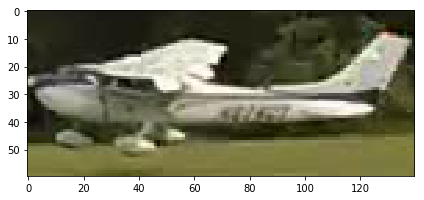

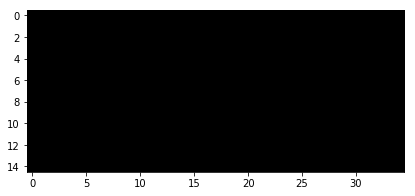

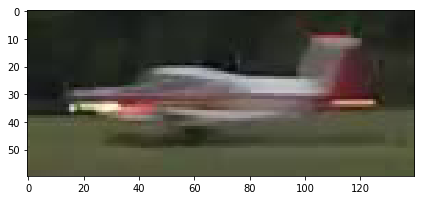

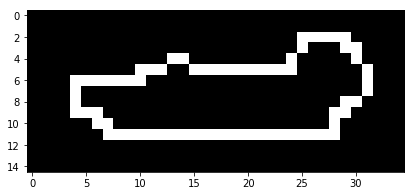

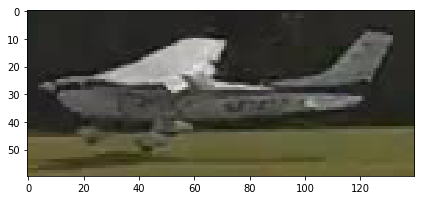

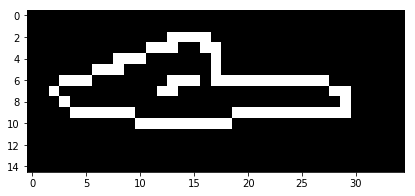

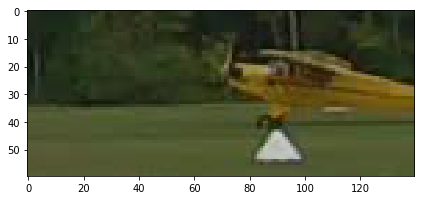

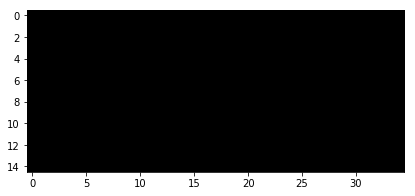

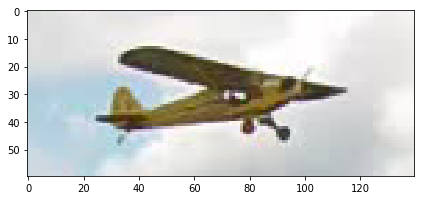

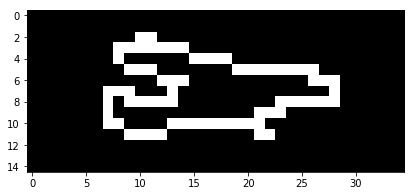

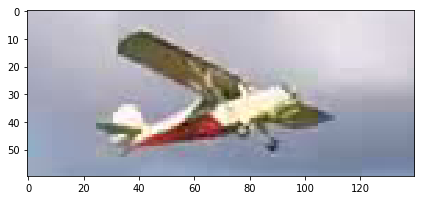

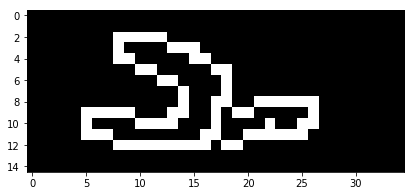

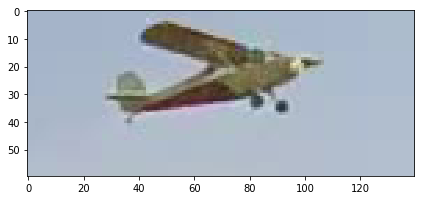

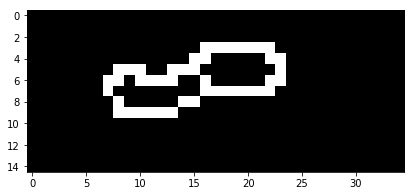

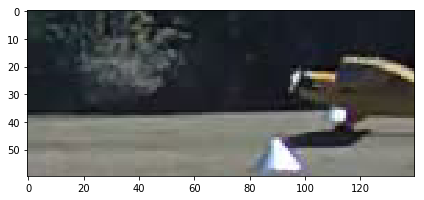

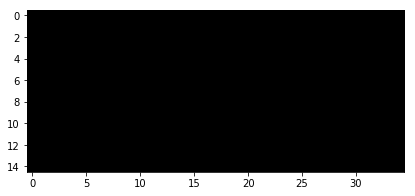

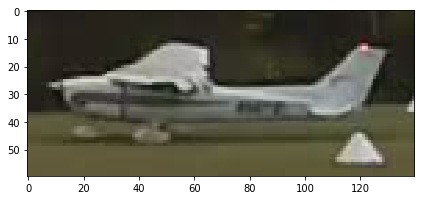

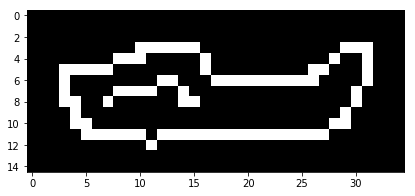

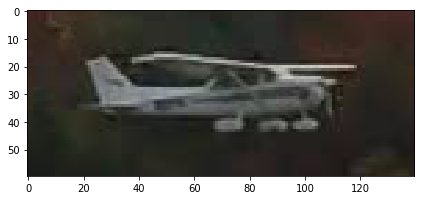

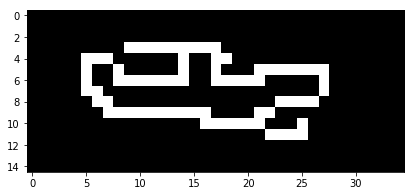

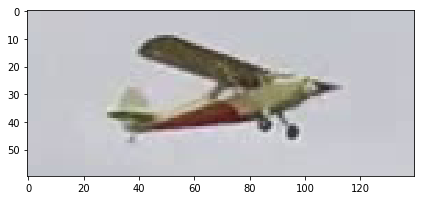

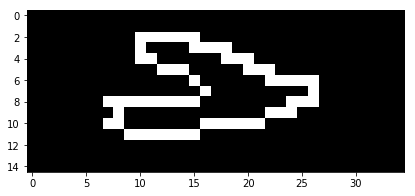

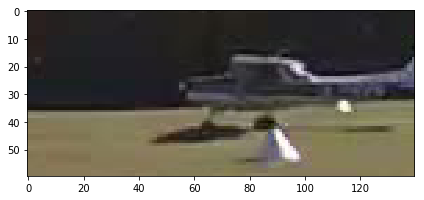

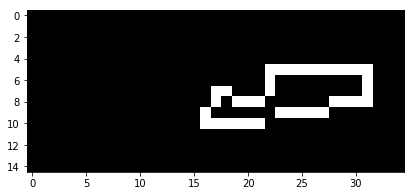

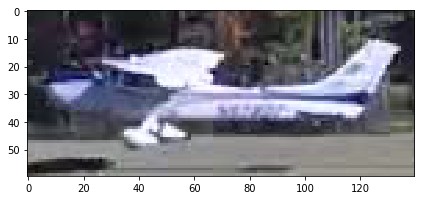

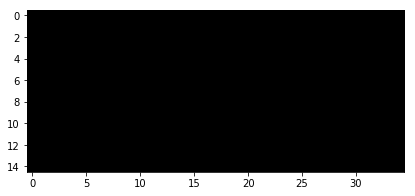

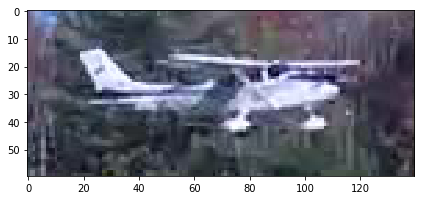

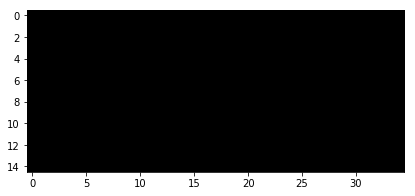

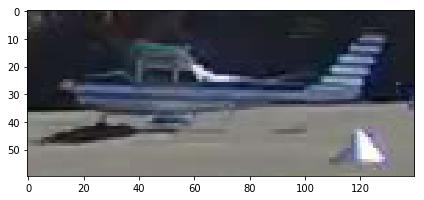

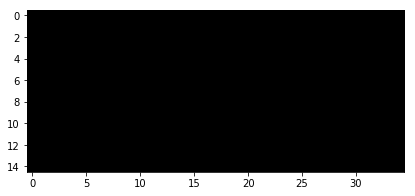

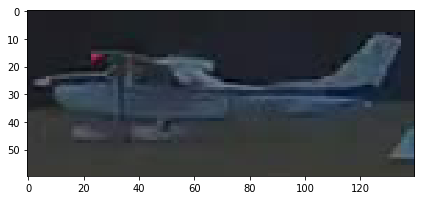

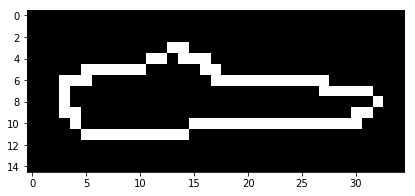

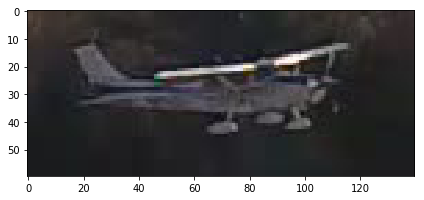

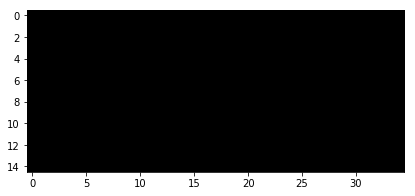

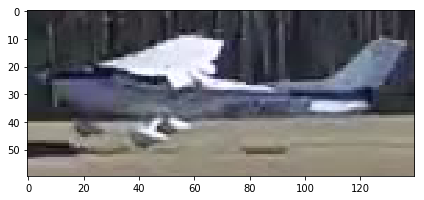

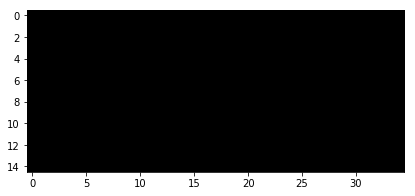

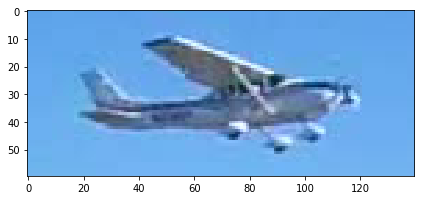

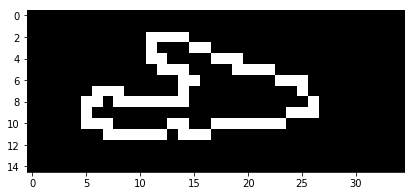

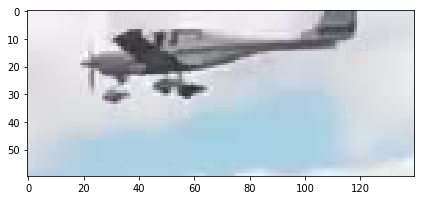

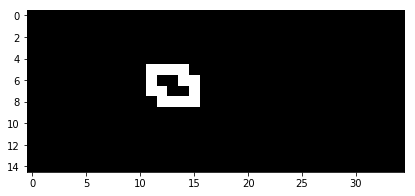

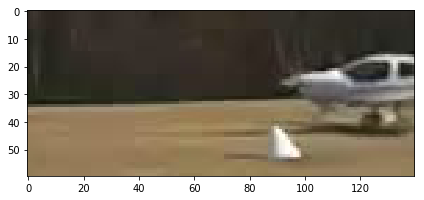

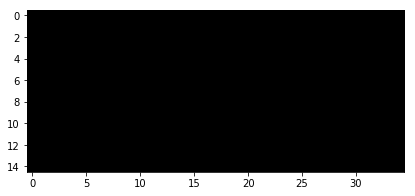

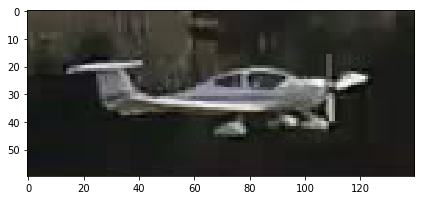

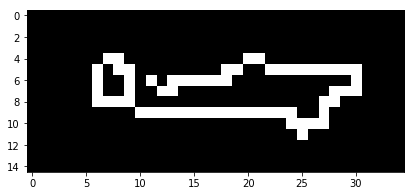

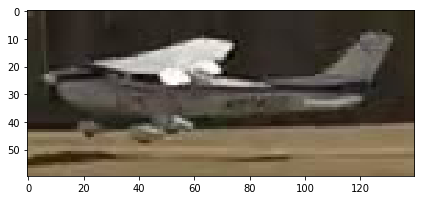

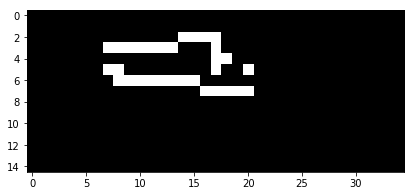

In [59]:
# print positives
for i in range(0, len(plane_data)):
    ##print(plane_data['img_name'][i] + " " + str(plane_data['plane'][i]))
    if plane_data['plane'][i] == True:
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + plane_data['img_name'][i] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        out = image_manipulation(plane_data['img_name'][i], imview=True)
        # io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')
        nTrue.append(out.sum())
        

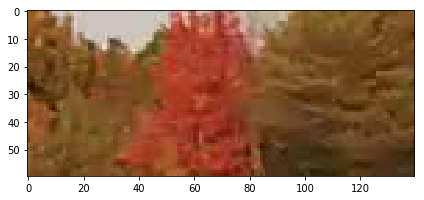

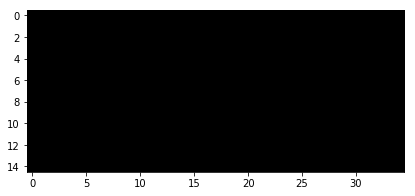

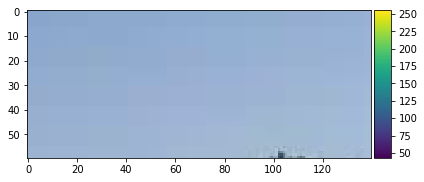

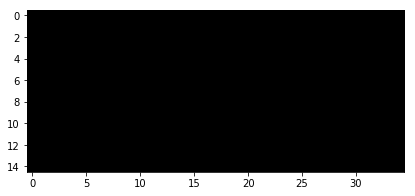

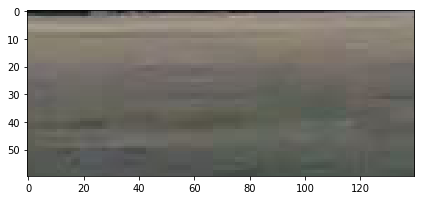

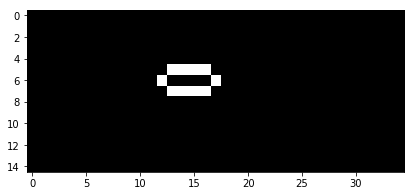

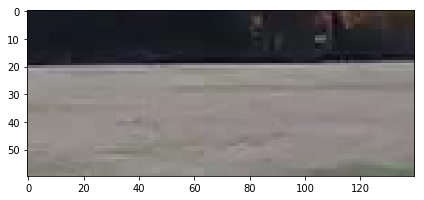

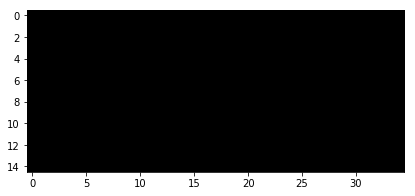

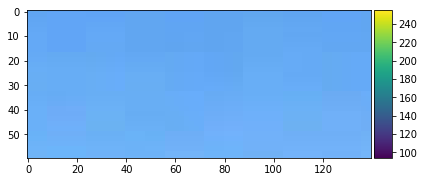

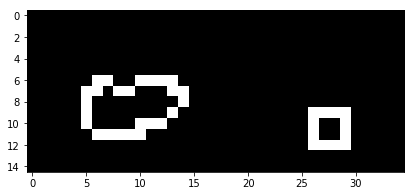

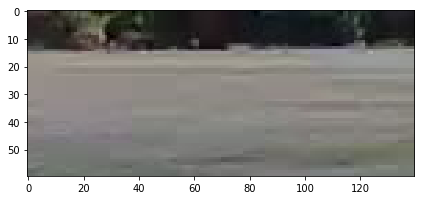

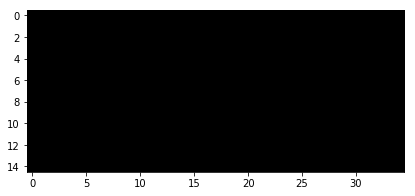

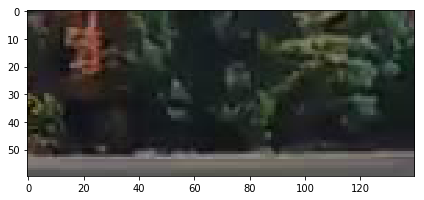

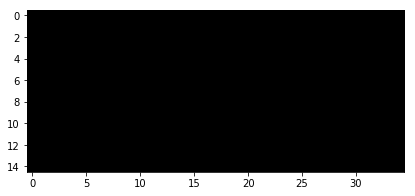

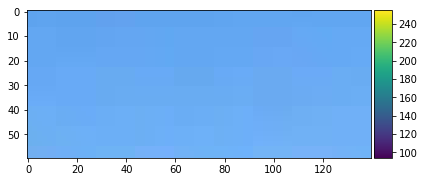

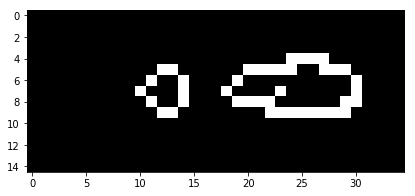

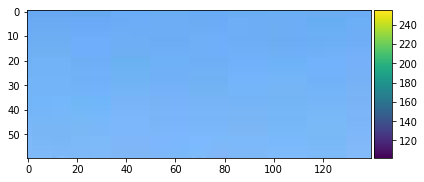

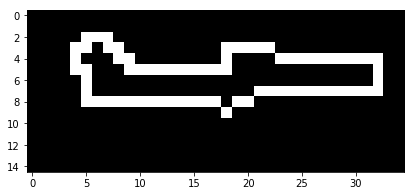

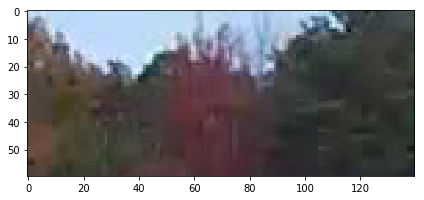

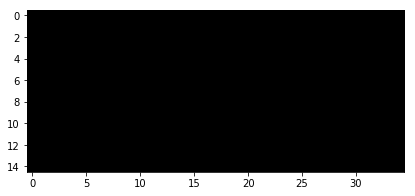

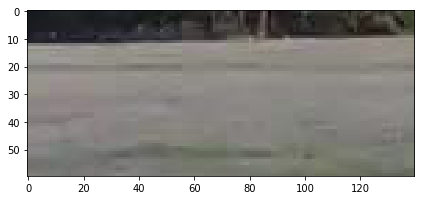

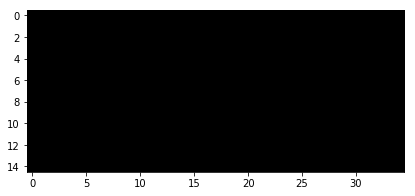

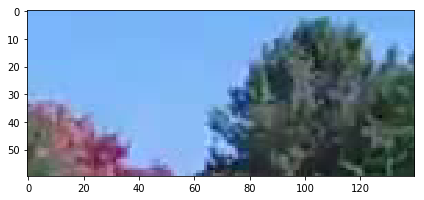

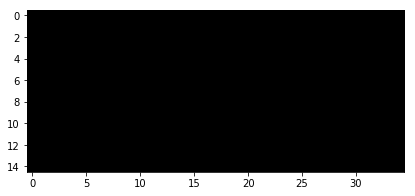

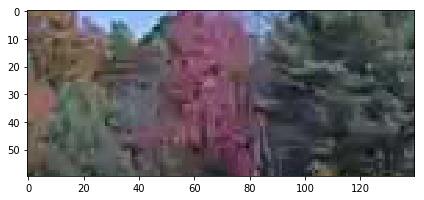

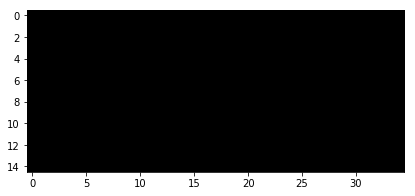

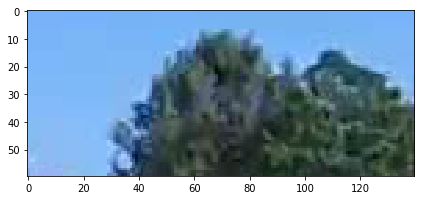

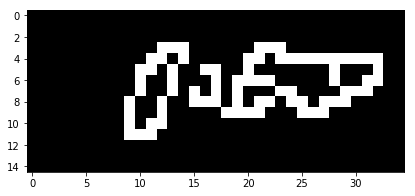

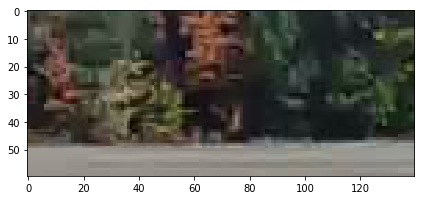

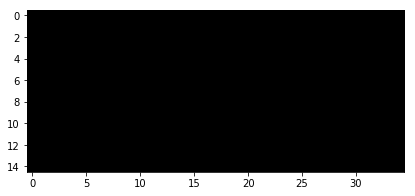

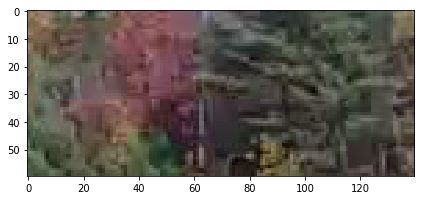

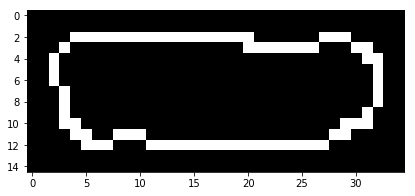

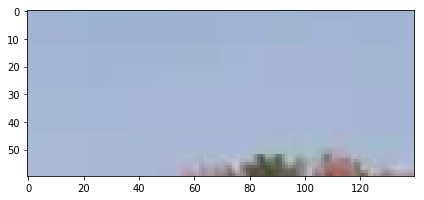

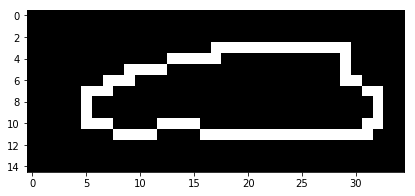

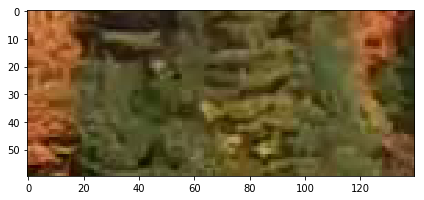

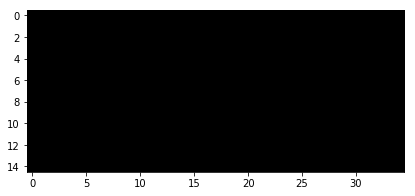

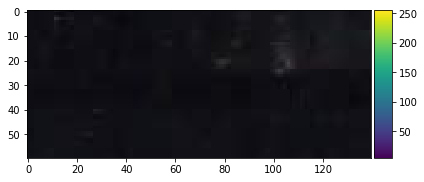

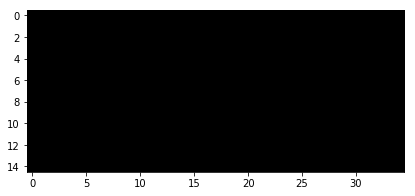

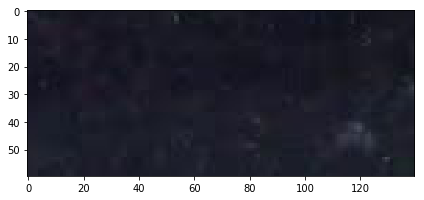

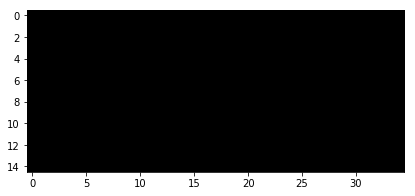

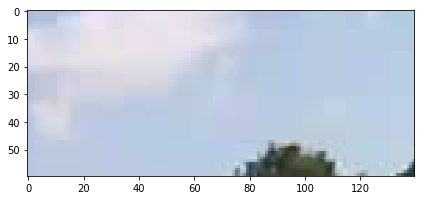

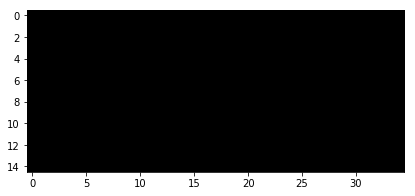

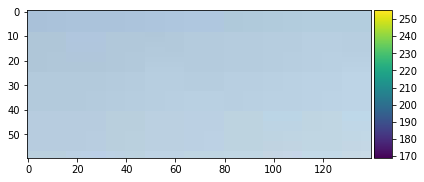

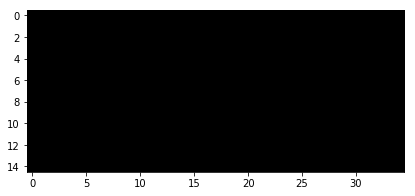

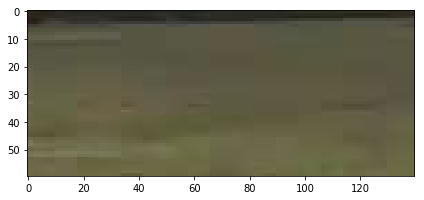

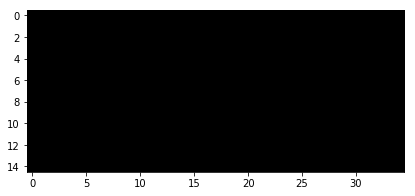

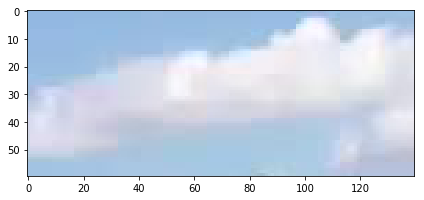

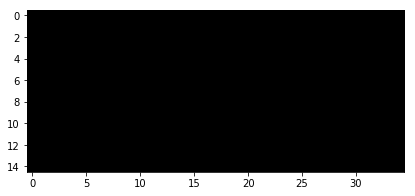

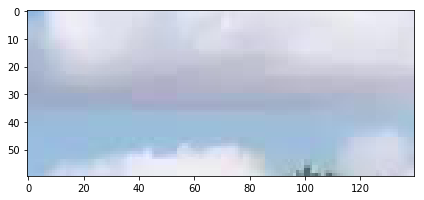

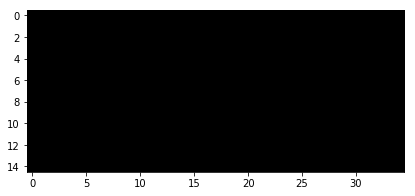

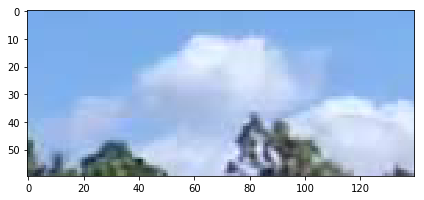

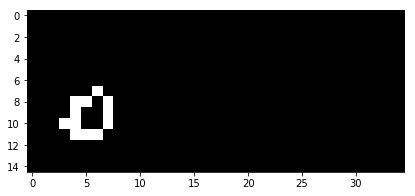

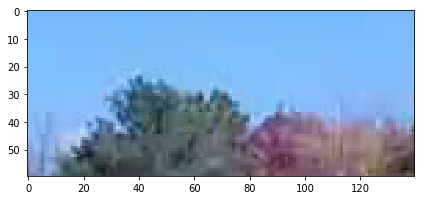

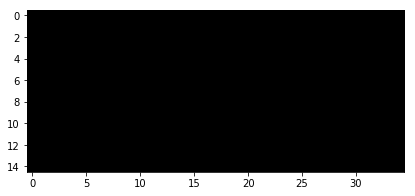

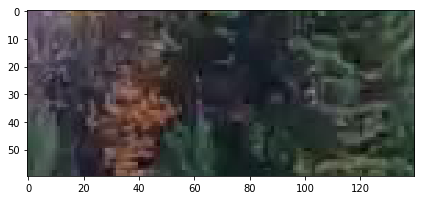

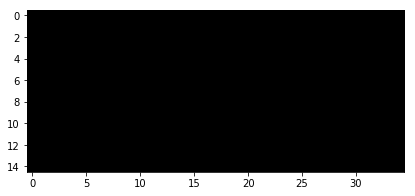

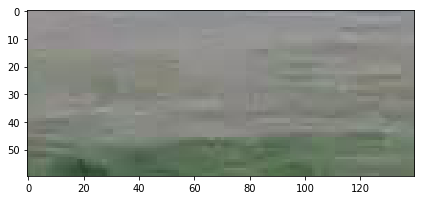

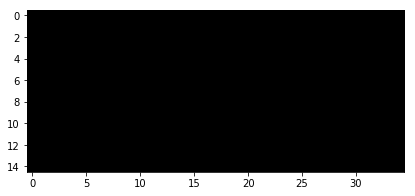

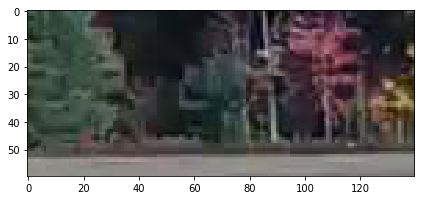

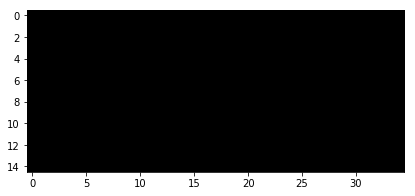

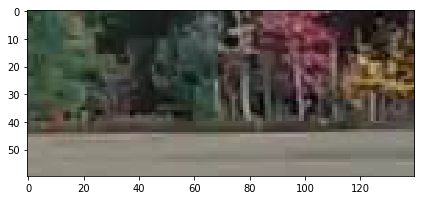

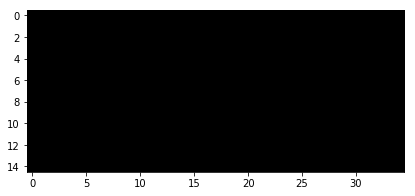

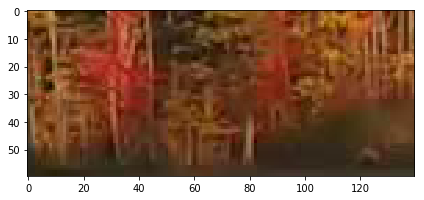

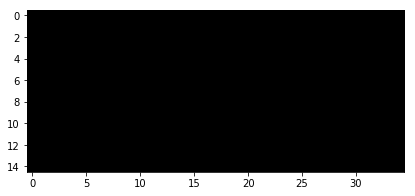

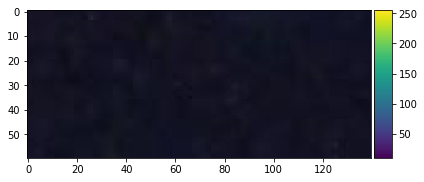

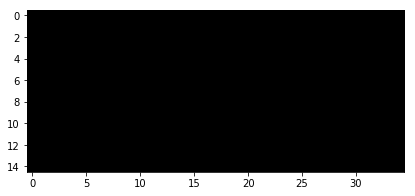

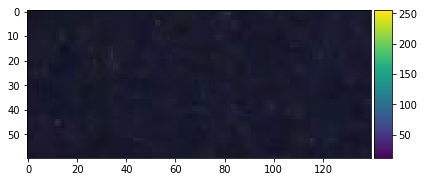

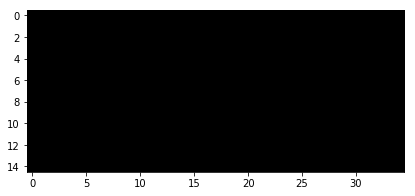

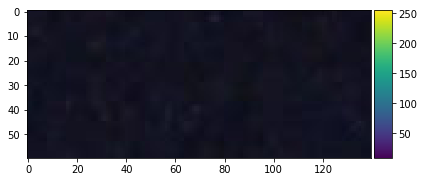

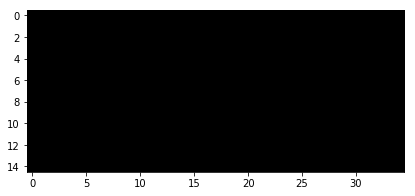

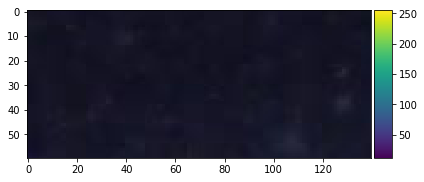

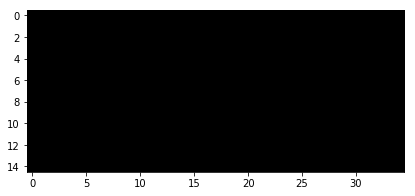

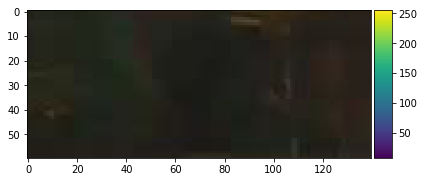

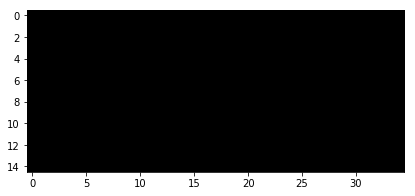

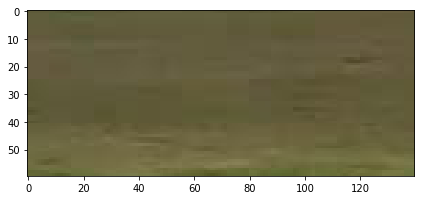

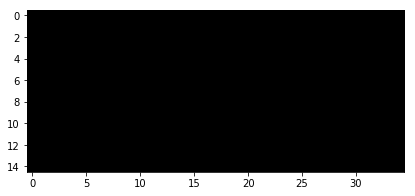

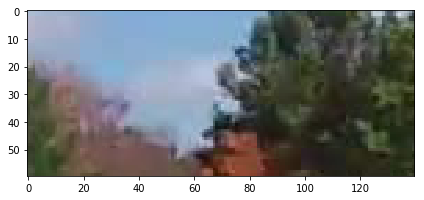

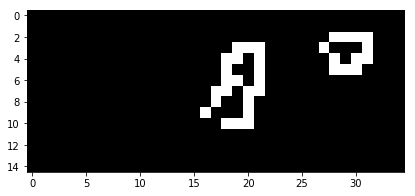

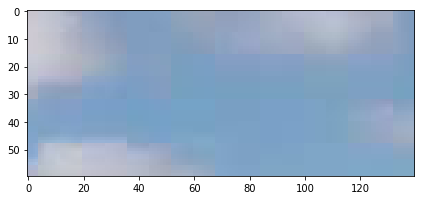

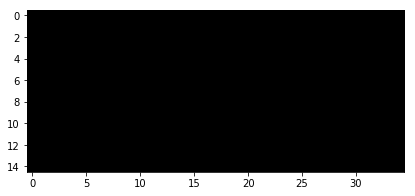

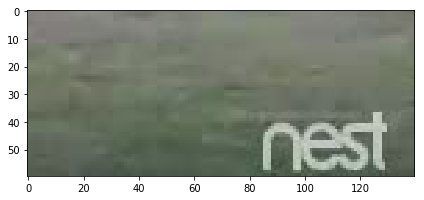

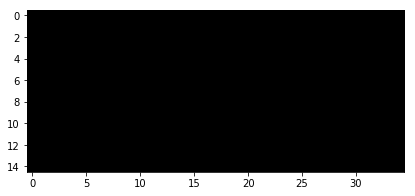

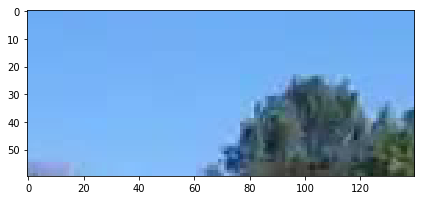

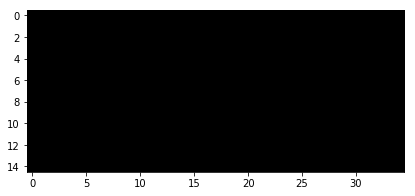

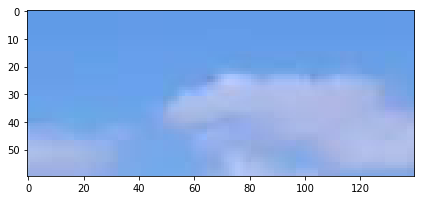

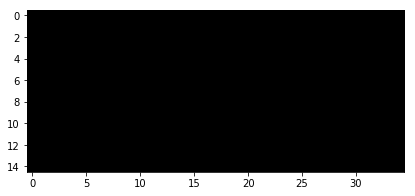

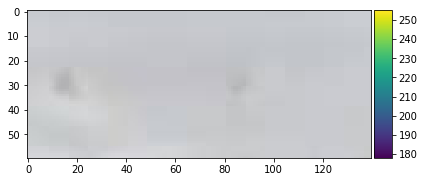

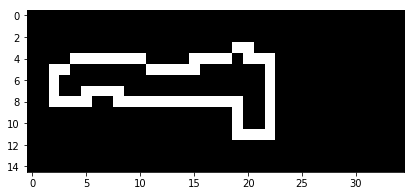

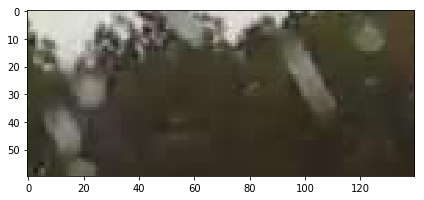

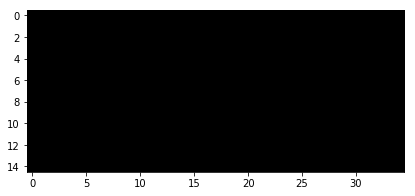

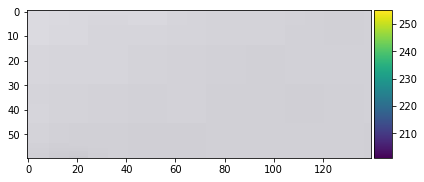

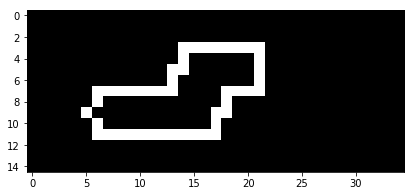

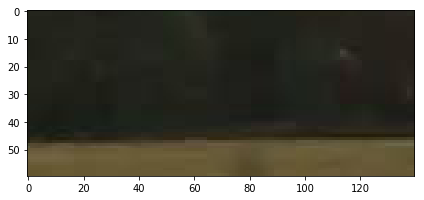

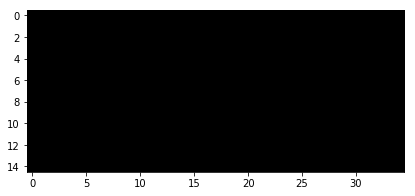

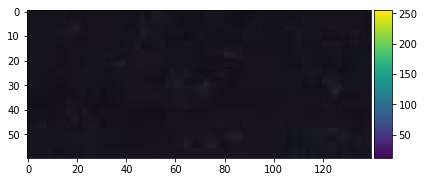

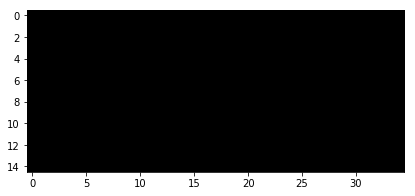

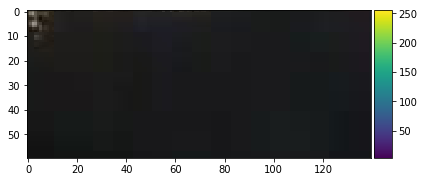

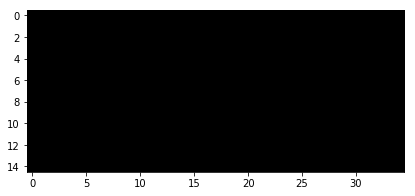

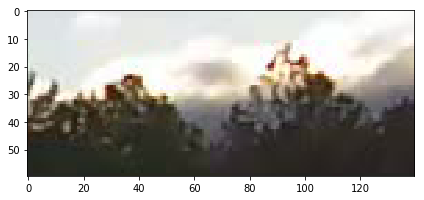

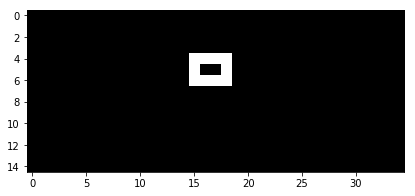

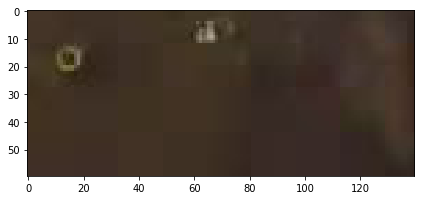

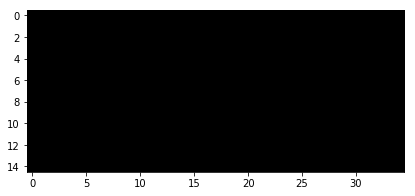

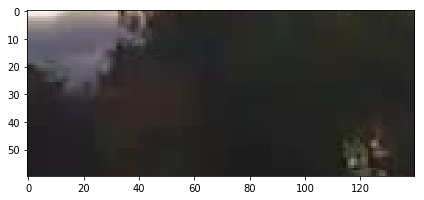

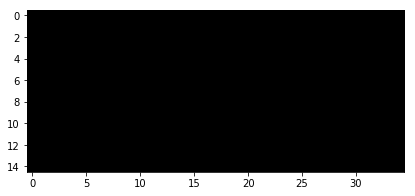

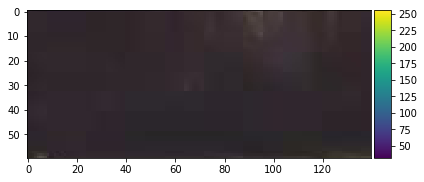

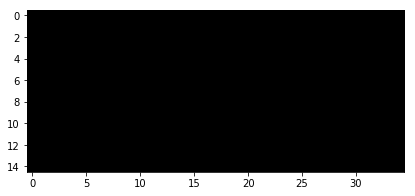

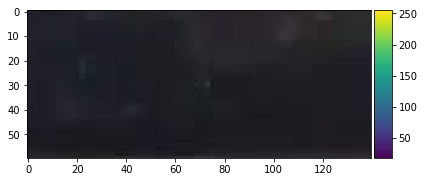

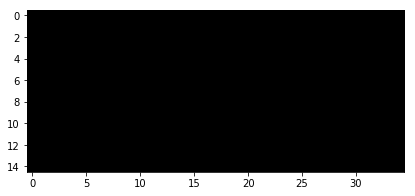

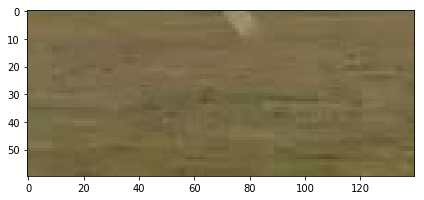

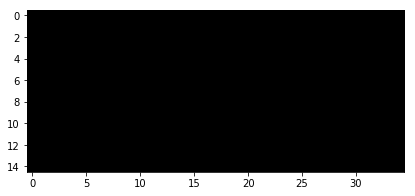

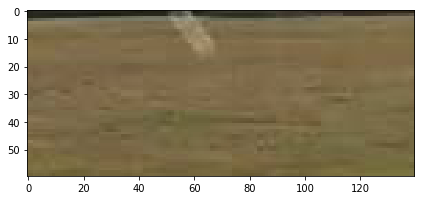

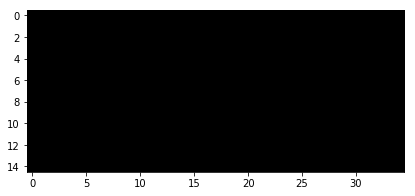

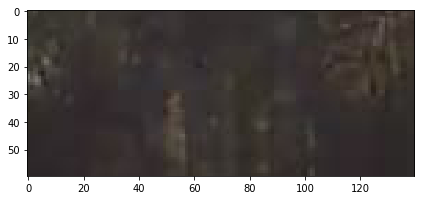

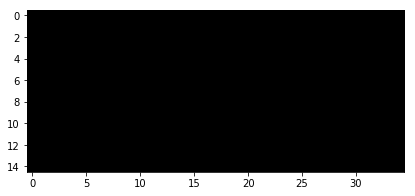

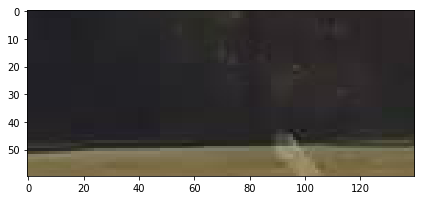

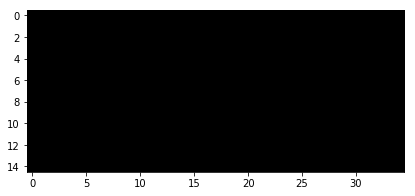

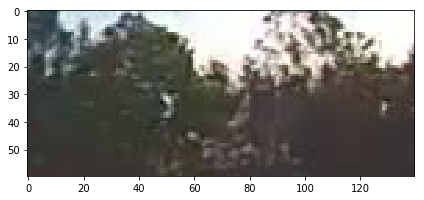

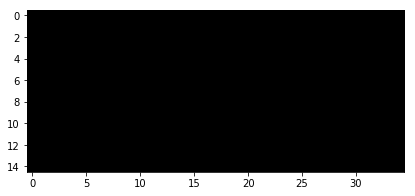

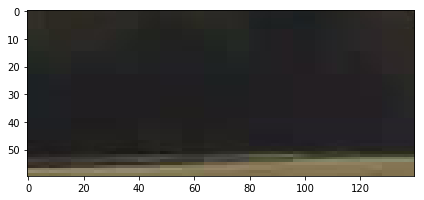

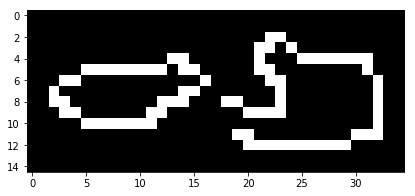

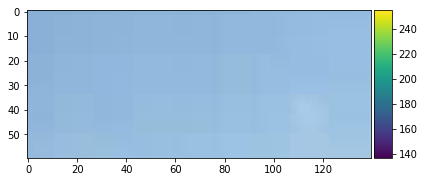

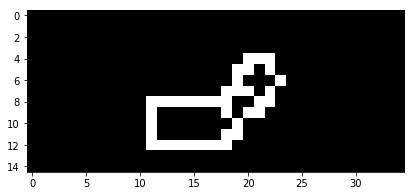

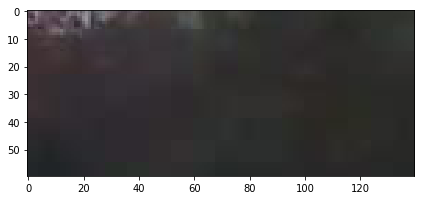

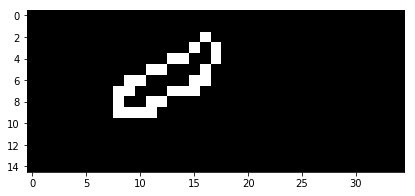

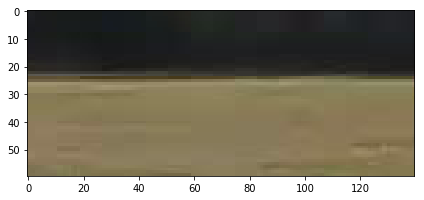

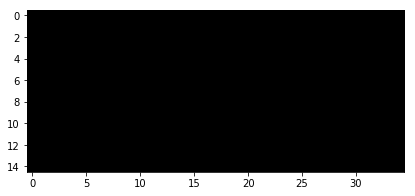

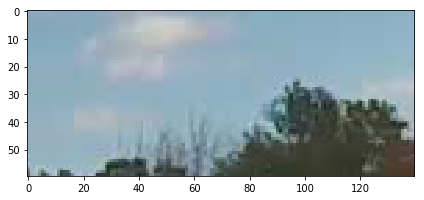

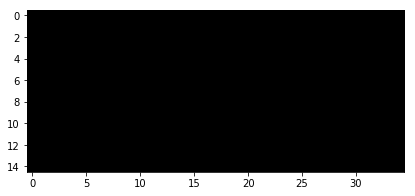

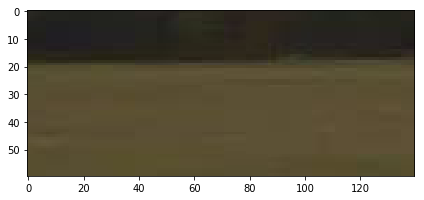

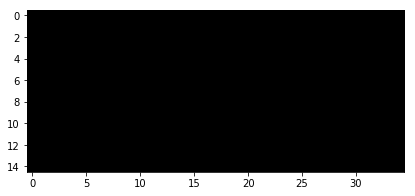

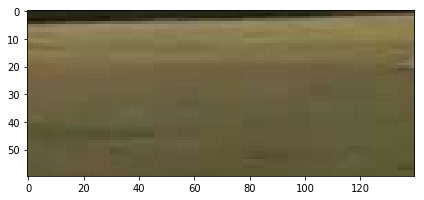

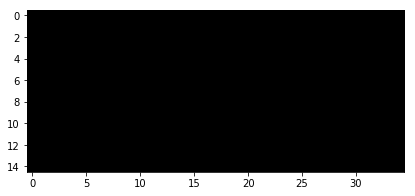

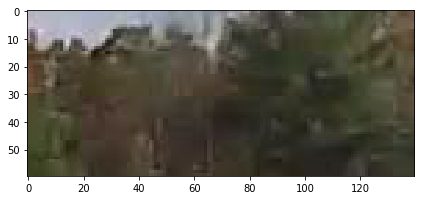

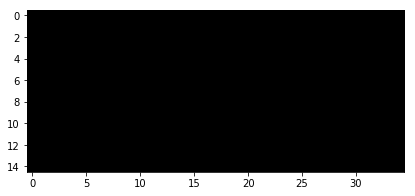

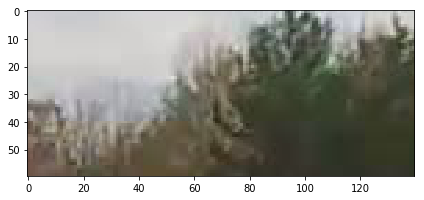

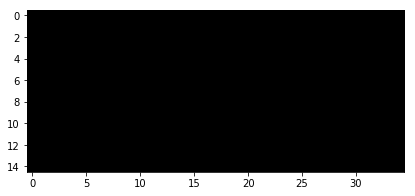

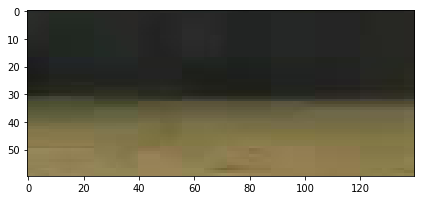

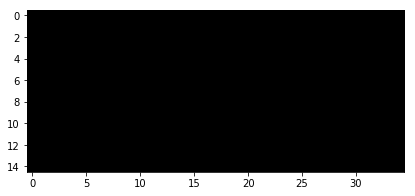

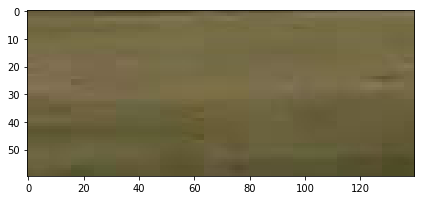

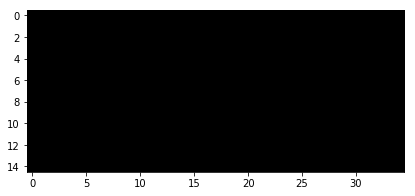

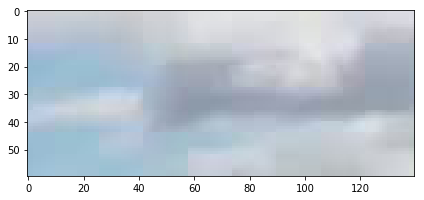

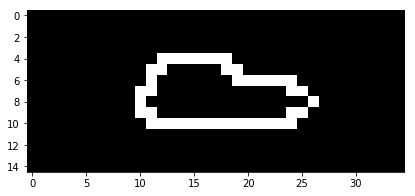

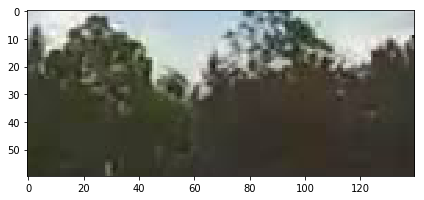

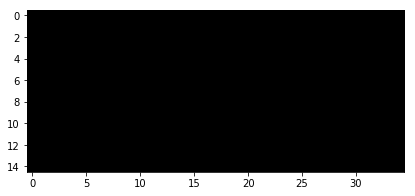

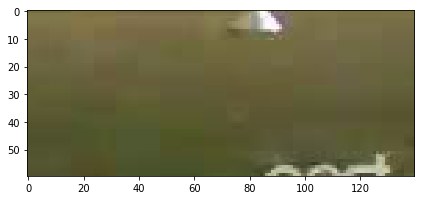

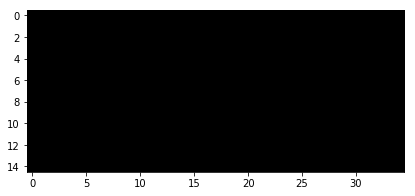

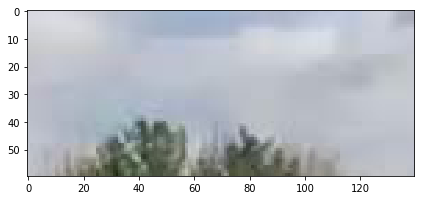

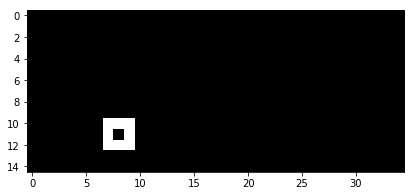

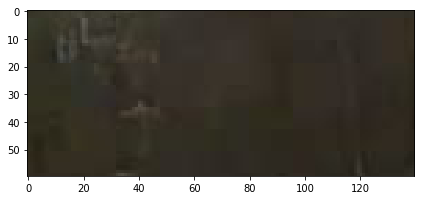

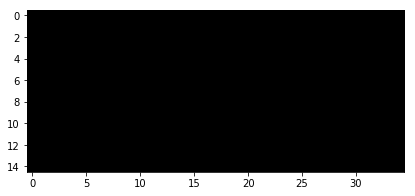

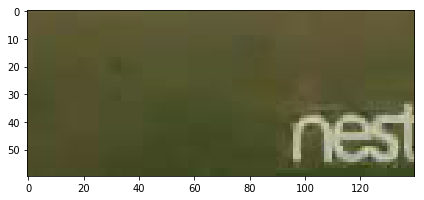

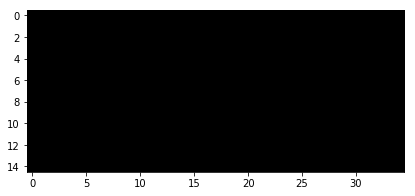

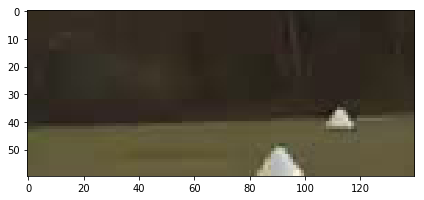

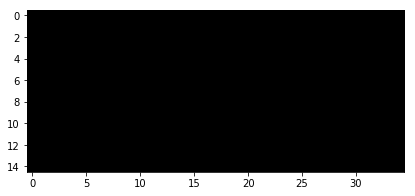

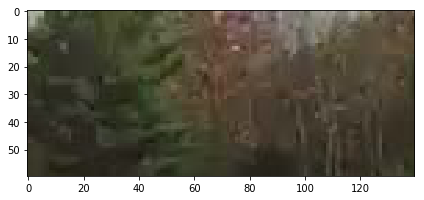

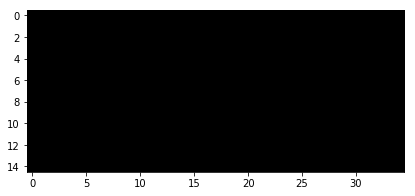

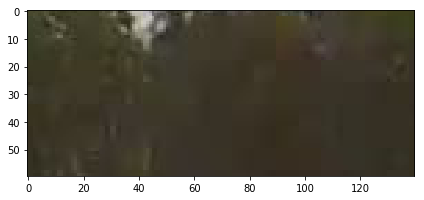

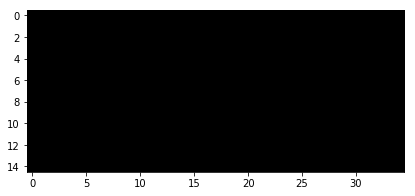

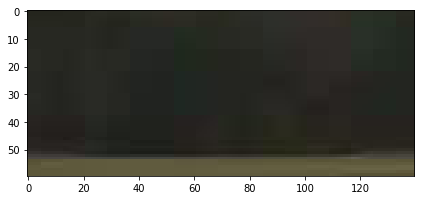

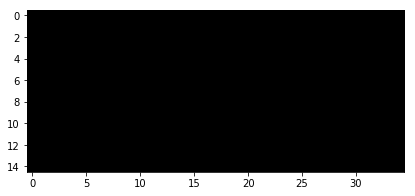

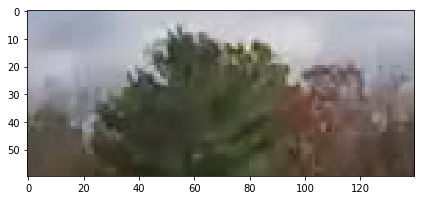

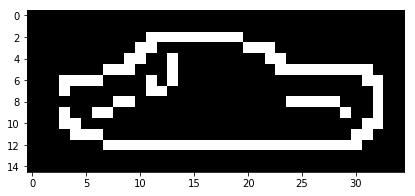

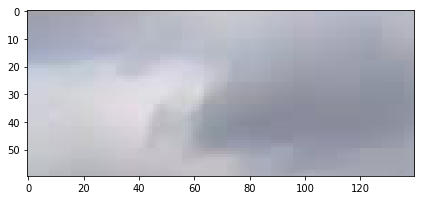

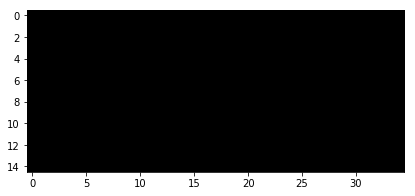

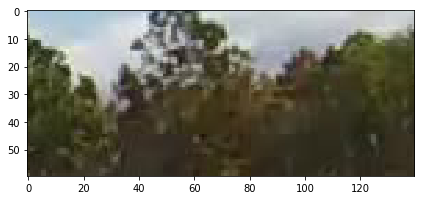

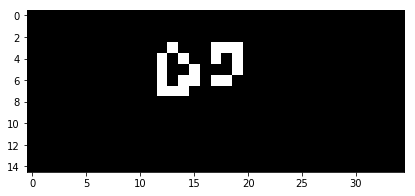

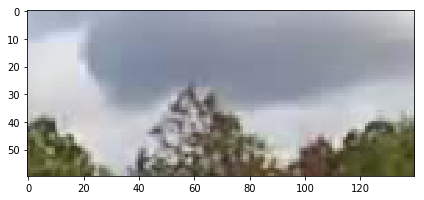

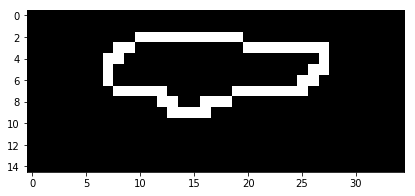

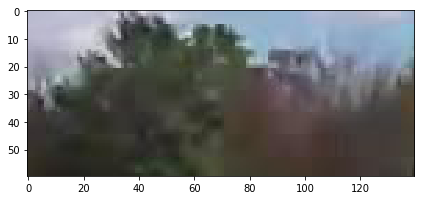

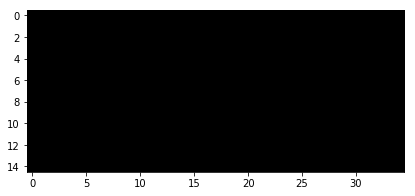

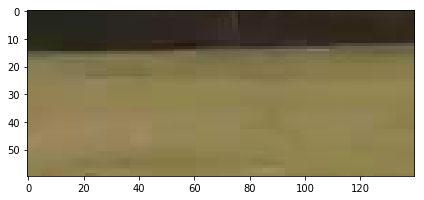

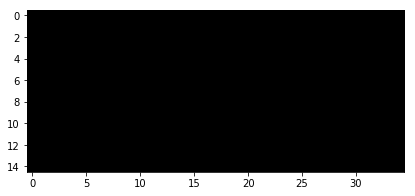

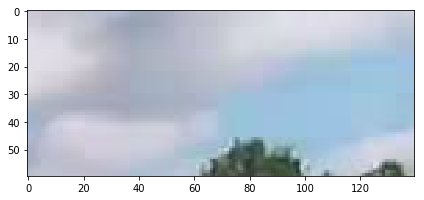

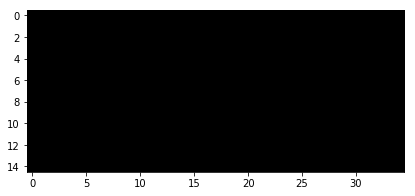

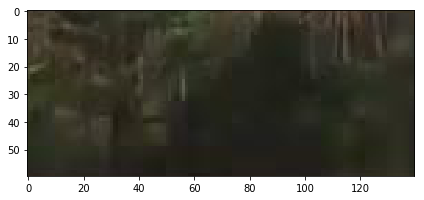

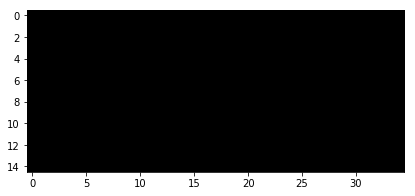

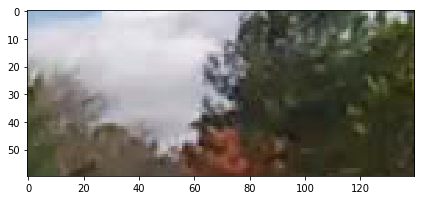

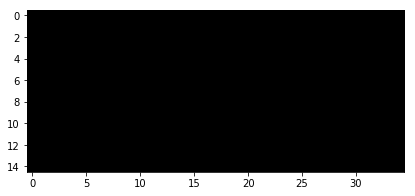

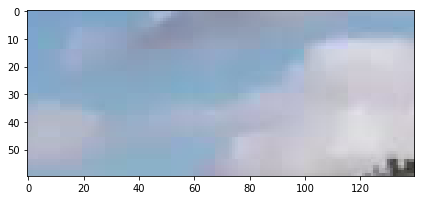

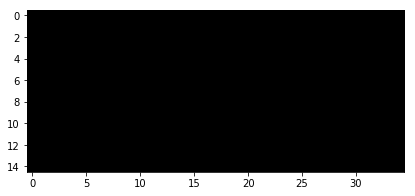

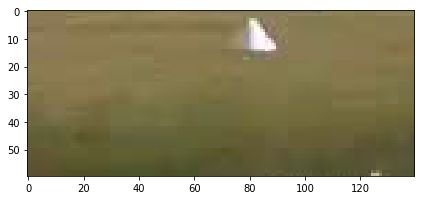

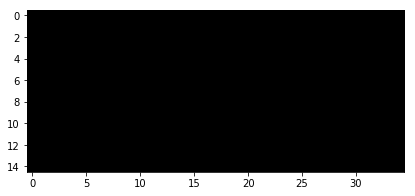

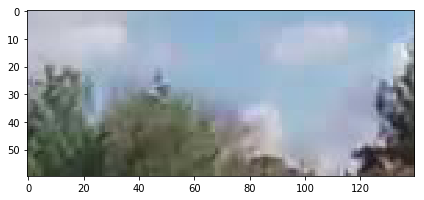

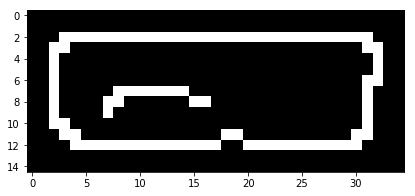

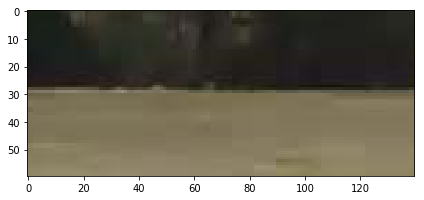

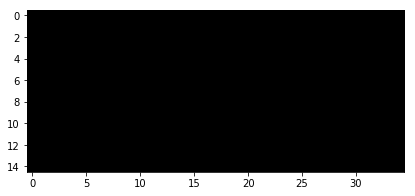

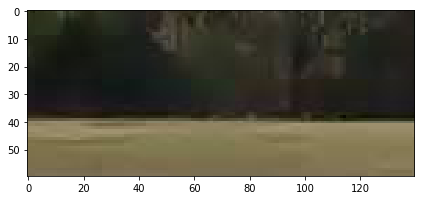

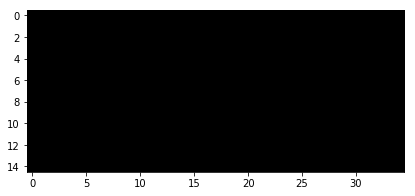

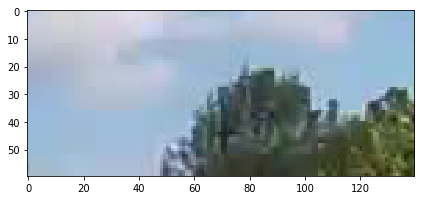

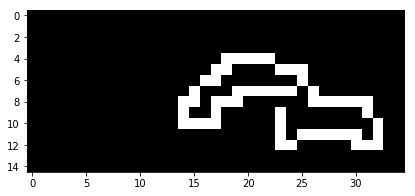

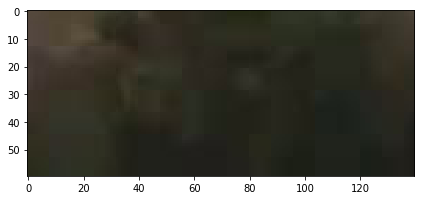

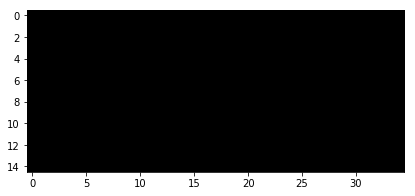

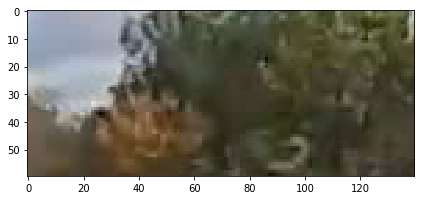

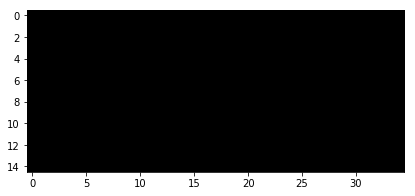

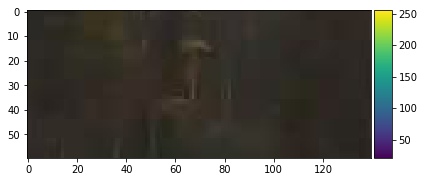

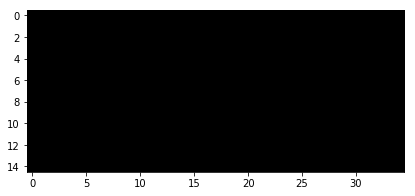

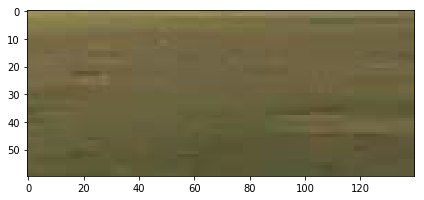

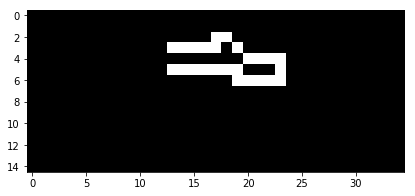

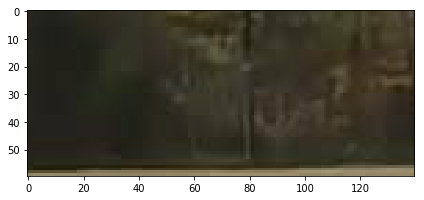

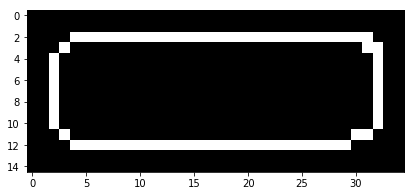

In [60]:
# print negatives
pcount = 0

for i in range(1000, len(plane_data)):
    ##print(plane_data['img_name'][i] + " " + str(plane_data['plane'][i]))
    if plane_data['plane'][i] == False and pcount < 100:
        pcount += 1;
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + plane_data['img_name'][i] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        out=image_manipulation(plane_data['img_name'][i], imview=True)
        # io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')
        s = out.sum()
        nFalse.append(out.sum())
        if s > 325:
          print(plane_data['img_name'][i])

(array([ 34.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,   1.,   0.,
          0.,   3.,   0.,   0.,   1.,   0.,   2.,   0.,   1.,   0.,   0.,
          2.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   4.,   2.,   0.,   2.,   3.,   2.,   2.,   0.,   1.,   2.,
          4.,   1.,   0.,   3.,   1.,   1.,   2.,   0.,   1.,   3.,   1.,
          3.,   0.,   2.,   2.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,
          1.]),
 array([  0. ,   0.8,   1.6,   2.4,   3.2,   4. ,   4.8,   5.6,   6.4,
          7.2,   8. ,   8.8,   9.6,  10.4,  11.2,  12. ,  12.8,  13.6,
         14.4,  15.2,  16. ,  16.8,  17.6,  18.4,  19.2,  20. ,  20.8,
         21.6,  22.4,  23.2,  24. ,  24.8,  25.6,  26.4,  27.2,  28. ,
         28.8,  29.6,  30.4,  31.2

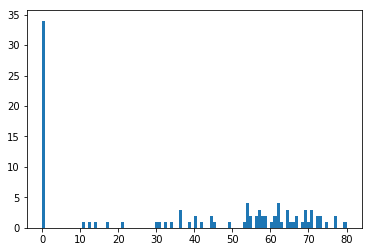

In [61]:
plt.hist(nTrue, 100)

1

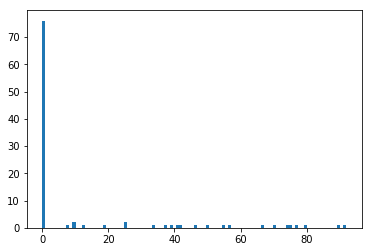

In [62]:
plt.hist(nFalse, 100)
1